In [1]:
import numpy as np
import pandas as pd
from math import ceil
from datetime import datetime, timedelta
import calendar
from sklearn.linear_model import LogisticRegression,LinearRegression
from xgboost.sklearn import XGBRegressor
from sklego.meta import ZeroInflatedRegressor
from sqlalchemy import create_engine
from prophet import Prophet
import inspect
from config import base_path
import os
from LazyProphet import LazyProphet as lp
# import pickle
import logging

In [2]:
## import Data  
def import_data():

    category_df = pd.read_excel(f"{base_path}/category_with_ID.xlsx",sheet_name='category')
    category_df = category_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    category_df['CategoryID'] = category_df['CategoryID'].astype(str)
    print('Category data shape',category_df.shape)

    property_data = pd.read_csv(f"{base_path}/filtered_with_feb_with_stand_name.csv",encoding = 'latin1' ,
                    usecols=['Booking Date','Gross Amount','Category','CategoryID','Property name','Item name','stand_name','Cost Center Name','Cost center'])
    property_data.rename(columns={'Booking Date':'Booking_Date','Gross Amount':'Gross_Amount','Property name':'Property_name', 'Item name':'Item_Name',
                                  'Category':'Category','CategoryID':'CategoryID','Cost center':'Cost_center','Cost Center Name':'Cost_Center_Name'}, inplace=True)
    property_data = property_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    property_data['Item_Name'] = property_data['Item_Name'].str.lower()
    print("consumption data shape:",property_data.shape)

    #Correcting one name in the item name list
    wrong_item = 'roissant, plain, butter, Bridor, eclat du terroir, 30gr, frozen'
    correct_item = 'c' + wrong_item

    property_data.loc[property_data['Item_Name'] == wrong_item,'Item_Name'] = correct_item

    # mapping_df = pd.read_excel(f"{base_path}/item_name_mapping.xlsx",sheet_name='mapping_sheet'
    #                            ,usecols=['Item_Name','Item_Name_Standard','Category_Standard','Remove_flag'])
    mapping_df = pd.read_csv(f"{base_path}/item_name_mapping.csv",encoding = 'latin1'
                                ,usecols=['Item_Name','Item_Name_Standard','Category_Standard','Remove_flag','CategoryID_Standard'])

    mapping_df = mapping_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    # mapping_df['Category_Standard'] = mapping_df['Category_Standard'].str.lower()
    mapping_df['Item_Name'] = mapping_df['Item_Name'].str.lower()
    mapping_df['Item_Name_Standard'] = mapping_df['Item_Name_Standard'].str.lower()
    mapping_df_ = mapping_df.drop_duplicates().reset_index(drop=True)
    mapping_df_['Remove_flag'] = mapping_df_['Remove_flag'].astype(str)
    mapping_df_ = mapping_df_[mapping_df_['Remove_flag']=='0']
    print('Mapping data shape',mapping_df_.shape)
    
    merged_property_data_df = pd.merge(property_data, mapping_df_[['Item_Name','Category_Standard','Item_Name_Standard','CategoryID_Standard']], on=['Item_Name'], how='inner')
    merged_property_data_df['CategoryID_Standard'] = merged_property_data_df['CategoryID_Standard'].astype(str)
    #### Get only 26 categories data
    final_data_set = merged_property_data_df[merged_property_data_df['CategoryID_Standard'].isin(category_df.CategoryID.tolist())].reset_index(drop=True)
    print('Final data shape',final_data_set.shape)
    

    return category_df,final_data_set

In [3]:
category_df,final_data_set = import_data()


Category data shape (26, 2)
consumption data shape: (204668, 9)
Mapping data shape (7941, 5)
Final data shape (204303, 12)


In [4]:
df = final_data_set.copy()

In [5]:
df.columns

Index(['Property_name', 'Booking_Date', 'Item_Name', 'stand_name', 'Category',
       'CategoryID', 'Cost_center', 'Cost_Center_Name', 'Gross_Amount',
       'Category_Standard', 'Item_Name_Standard', 'CategoryID_Standard'],
      dtype='object')

In [6]:
df['uniqueID'] = df['Property_name'] + '__' + df['Cost_center'] + '__' + df['Category_Standard'] + '__' + df['Item_Name_Standard']
df.head()

Property_name Booking_Date  \
0          PDCC    7/21/2021   
1          PDCC    6/11/2021   
2          PDCC    6/11/2021   
3          PDCC    6/11/2021   
4          PDCC    6/16/2021   

                                           Item_Name stand_name  \
0  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
1  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
2  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
3  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
4  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   

                     Category  CategoryID       Cost_center  \
0  LS - Bakery Products Fresh       21551  2990_70120.H2022   
1  LS - Bakery Products Fresh       21551  2990_70120.H2022   
2  LS - Bakery Products Fresh       21551  2990_70120.H2022   
3  LS - Bakery Products Fresh       21551  2990_70120.H2022   
4  LS - Bakery Products Fresh       21551  2990_70120.H2022   

       Cost_Center_Name  Gross_Amount           Category_Standard  \
0  H2022 - Main Kitchen        34.650  LS - Bakery Products Fresh   
1  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
2  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
3  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
4  H2022 - Main Kitchen        23.100  LS - Bakery Products Fresh   

  Item_Name_Standard CategoryID_Standard  \
0          bread pan               21551   
1          bread pan               21551   
2          bread pan               21551   
3          bread pan               21551   
4          bread pan               21551   

                                            uniqueID  
0  PDCC__2990_70120.H2022__LS - Bakery Products F...  
1  PDCC__2990_70120.H2022__LS - Bakery Products F...  
2  PDCC__2990_70120.H2022__LS - Bakery Products F...  
3  PDCC__2990_70120.H2022__LS - Bakery Products F...  
4  PDCC__2990_70120.H2022__LS - Bakery Products F...

In [7]:
df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])

In [8]:
def get_days_week_month_count(df):

    # Add a new column 'Year'
    df['Year'] = df['Booking_Date'].dt.isocalendar().year
    # Add a new column 'Week of Year'
    df['Week_of_Year'] = df['Booking_Date'].dt.isocalendar().week

    df['week_year'] = df['Year'].astype(str) + '-' + df['Week_of_Year'].astype(str)

    # Group the original dataframe by 'Unique ID'
    grouped_df = df.groupby(['uniqueID']).agg(
        no_of_days=('Booking_Date', 'nunique'),  # Count the number of unique booking dates
        no_of_weeks=('week_year', 'nunique'),
        no_of_months=('Booking_Date', lambda x: x.dt.to_period('M').nunique()),
        last_Trx_Date = ('Booking_Date', 'max')).reset_index()
    
    grouped_df['lastest_date'] = grouped_df.last_Trx_Date.max()
    grouped_df['months_difference'] = (grouped_df['lastest_date'].dt.to_period('M') - grouped_df['last_Trx_Date'].dt.to_period('M'))
    grouped_df['months_difference'] = grouped_df['months_difference'].apply(lambda x: x.n)
    
    #### Filter uniqueIDs which has more week numbers
    grouped_df_more_week_df = grouped_df[~((grouped_df['no_of_days'] < 11) | (grouped_df['months_difference'] >= 4))]
    more_week_count_list_ = grouped_df_more_week_df.uniqueID.tolist()
    print('Selected Unique IDs count: ',len(more_week_count_list_))
    print('Selected Unique IDs: ',more_week_count_list_)


    #### Filter uniqueIDs which has less week numbers
    grouped_df_less_week_df = grouped_df[(grouped_df['no_of_days']< 11) | (grouped_df['months_difference']>= 4)]  #### filter less than or equal 10 records and last 4 month does not happend any purchase
    less_count_unique_ids_list = grouped_df_less_week_df.uniqueID.tolist()

    print('Unselected Unique IDs count: ',len(less_count_unique_ids_list))
    print('Unselected Unique IDs: ',less_count_unique_ids_list)
    # dfgs = pd.DataFrame(less_count_unique_ids_list, columns=['unique_id'])
    # dfgs.to_csv('test.csv')

    return more_week_count_list_, less_count_unique_ids_list

In [9]:
more_week_count_list_,_= get_days_week_month_count(df)
more_week_count_list_

Selected Unique IDs count:  1411
Selected Unique IDs:  ['ADAGIO__1300_72885.HA609__LS - Cleaning Products__cleanser', 'ADAGIO__1300_72885.HA609__LS - Cleaning Products__garbage bag', 'ADAGIO__1300_72885.HA609__LS - Cleaning Products__shampoo', 'ADAGIO__1300_72885.HA609__LS - Consumables__paper towel', 'ADAGIO__1300_72885.HA609__LS - Consumables__photocopy paper', 'ADAGIO__1300_72885.HA609__LS - Consumables__toilet paper roll', 'ADAGIO__2115_72885.HA609__LS - Consumables__cup lid', 'ADAGIO__2115_72885.HA609__LS - Consumables__lunch box', 'ADAGIO__2115_72885.HA609__LS - Consumables__napkin', 'ADAGIO__2115_72885.HA609__LS - Consumables__paper bag', 'ADAGIO__2115_72885.HA609__LS - Consumables__paper cup', 'ADAGIO__2115_72885.HA609__LS - Consumables__paper roll', 'ADAGIO__2115_72885.HA609__LS - Dairy Products Fresh__milk oat', 'ADAGIO__2115_72885.HA609__LS - Dairy products chilled/frozen__coconut milk', 'ADAGIO__2115_72885.HA609__LS - Dairy products chilled/frozen__milk', 'ADAGIO__2115_7288

['ADAGIO__1300_72885.HA609__LS - Cleaning Products__cleanser',
 'ADAGIO__1300_72885.HA609__LS - Cleaning Products__garbage bag',
 'ADAGIO__1300_72885.HA609__LS - Cleaning Products__shampoo',
 'ADAGIO__1300_72885.HA609__LS - Consumables__paper towel',
 'ADAGIO__1300_72885.HA609__LS - Consumables__photocopy paper',
 'ADAGIO__1300_72885.HA609__LS - Consumables__toilet paper roll',
 'ADAGIO__2115_72885.HA609__LS - Consumables__cup lid',
 'ADAGIO__2115_72885.HA609__LS - Consumables__lunch box',
 'ADAGIO__2115_72885.HA609__LS - Consumables__napkin',
 'ADAGIO__2115_72885.HA609__LS - Consumables__paper bag',
 'ADAGIO__2115_72885.HA609__LS - Consumables__paper cup',
 'ADAGIO__2115_72885.HA609__LS - Consumables__paper roll',
 'ADAGIO__2115_72885.HA609__LS - Dairy Products Fresh__milk oat',
 'ADAGIO__2115_72885.HA609__LS - Dairy products chilled/frozen__coconut milk',
 'ADAGIO__2115_72885.HA609__LS - Dairy products chilled/frozen__milk',
 'ADAGIO__2115_72885.HA609__LS - Dairy products chilled/fro

In [10]:
len(more_week_count_list_)

1411

In [11]:
filtered_df = df[df['uniqueID'].isin(more_week_count_list_)]
filtered_df.head()

Property_name Booking_Date  \
0          PDCC   2021-07-21   
1          PDCC   2021-06-11   
2          PDCC   2021-06-11   
3          PDCC   2021-06-11   
4          PDCC   2021-06-16   

                                           Item_Name stand_name  \
0  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
1  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
2  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
3  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   
4  bread, pan, sliced, super jumbo, brown, 1kg, f...  Bread pan   

                     Category  CategoryID       Cost_center  \
0  LS - Bakery Products Fresh       21551  2990_70120.H2022   
1  LS - Bakery Products Fresh       21551  2990_70120.H2022   
2  LS - Bakery Products Fresh       21551  2990_70120.H2022   
3  LS - Bakery Products Fresh       21551  2990_70120.H2022   
4  LS - Bakery Products Fresh       21551  2990_70120.H2022   

       Cost_Center_Name  Gross_Amount           Category_Standard  \
0  H2022 - Main Kitchen        34.650  LS - Bakery Products Fresh   
1  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
2  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
3  H2022 - Main Kitchen        28.875  LS - Bakery Products Fresh   
4  H2022 - Main Kitchen        23.100  LS - Bakery Products Fresh   

  Item_Name_Standard CategoryID_Standard  \
0          bread pan               21551   
1          bread pan               21551   
2          bread pan               21551   
3          bread pan               21551   
4          bread pan               21551   

                                            uniqueID  Year  Week_of_Year  \
0  PDCC__2990_70120.H2022__LS - Bakery Products F...  2021            29   
1  PDCC__2990_70120.H2022__LS - Bakery Products F...  2021            23   
2  PDCC__2990_70120.H2022__LS - Bakery Products F...  2021            23   
3  PDCC__2990_70120.H2022__LS - Bakery Products F...  2021            23   
4  PDCC__2990_70120.H2022__LS - Bakery Products F...  2021            24   

  week_year  
0   2021-29  
1   2021-23  
2   2021-23  
3   2021-23  
4   2021-24

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from math import ceil
import datetime
import calendar
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate mean absolute percentage error."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
def calculate_smape(actual, predicted):
    absolute_diff = np.abs(actual - predicted)
    sum_absolute = np.abs(actual) + np.abs(predicted)
    mask = sum_absolute != 0
    smape = np.mean(200 * (absolute_diff[mask] / sum_absolute[mask]))
    return smape

In [17]:
# Handle negative values in forecasted data
def replace_negatives_with_weighted_average(forecast_data):
    """
    Replace weighted average of non-neg values for neg values in fcst data 
    """
    replaced_count = 0
    updated_forecast = forecast_data.copy()
    for i, val in enumerate(forecast_data):
        if val < 0:  # Handle negative values
            closest_non_negative_1 = None
            closest_non_negative_2 = None
            distance_1 = None
            distance_2 = None
            # Find the two closest non-negative numbers
            for j in range(1, min(i+1, len(forecast_data)-i)):
                if forecast_data[i-j] >= 0:
                    closest_non_negative_1 = forecast_data[i-j]
                    distance_1 = j
                if forecast_data[i+j] >= 0:
                    closest_non_negative_2 = forecast_data[i+j]
                    distance_2 = j
                if closest_non_negative_1 is not None and closest_non_negative_2 is not None:
                    break
            # Compute the weights based on the inverse of the distances
            if closest_non_negative_1 is not None and closest_non_negative_2 is not None:
                weight_1 = 1 / (distance_1 + 1)  # Adding 1 to avoid division by zero
                weight_2 = 1 / (distance_2 + 1)  # Adding 1 to avoid division by zero
                total_weight = weight_1 + weight_2
                weighted_avg = (closest_non_negative_1 * weight_1 + closest_non_negative_2 * weight_2) / total_weight
                updated_forecast[i] = weighted_avg
            replaced_count+=1 
    return updated_forecast, replaced_count

In [18]:
filtered_df.columns

Index(['Property_name', 'Booking_Date', 'Item_Name', 'stand_name', 'Category',
       'CategoryID', 'Cost_center', 'Cost_Center_Name', 'Gross_Amount',
       'Category_Standard', 'Item_Name_Standard', 'CategoryID_Standard',
       'uniqueID', 'Year', 'Week_of_Year', 'week_year'],
      dtype='object')

In [19]:
filtered_df = filtered_df.rename(columns={'Booking_Date': 'booking_date', 'Gross_Amount': 'gross_amount'})

In [68]:
filtered_df_1 = filtered_df[filtered_df['Property_name']=='IRIGGA']

In [69]:
unique_ids=filtered_df_1.uniqueID.unique()

In [70]:
filtered_df_ = filtered_df_1[['uniqueID','booking_date','gross_amount']]

In [71]:
filtered_df_.head()

uniqueID booking_date  \
1852  IRIGGA__2990_70119.H6685__LS - Fruit Fresh__ba...   2022-01-04   
1853  IRIGGA__2990_70119.H6685__LS - Fruit Fresh__ba...   2022-01-04   
1854  IRIGGA__2990_70119.H6685__LS - Fruit Fresh__ba...   2022-01-04   
1855  IRIGGA__2990_70119.H6685__LS - Fruit Fresh__ba...   2022-01-04   
1856  IRIGGA__2990_70119.H6685__LS - Fruit Fresh__ba...   2022-01-05   

      gross_amount  
1852        6.8250  
1853        6.8250  
1854        6.8250  
1855        3.4125  
1856        6.8250

In [72]:
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import io
doc = Document()

results_list = []
combined_df = pd.DataFrame(columns=['booking_date', 'uniqueID', 'gross_amount', 'predicted'])




for i in unique_ids:
    try:
        df_filtered = filtered_df_[(filtered_df_['uniqueID'] == i)]
        # df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
        df_filtered.set_index('booking_date', inplace=True)
        df_filtered = df_filtered.resample('D').sum()
        df_filtered.reset_index('booking_date',inplace=True)
        last_booking_date = df_filtered['booking_date'].max()
        date_range = pd.date_range(start=last_booking_date + pd.DateOffset(days=1), end='2024-02-29')
        missing_dates_df = pd.DataFrame({'booking_date': date_range, 'gross_amount': 0, 'unique_id':0})
        filled_df = pd.concat([df_filtered, missing_dates_df])
        filled_df = filled_df.sort_values('booking_date')
        df_filtered=filled_df.copy()
        df_filtered = df_filtered.set_index('booking_date')

        df_filtered = df_filtered[['gross_amount']]
#         df_filtered = df_filtered.resample('M').sum()


        sunday_dates = []

        def week_of_month(dt):
            """ Returns the week of the month for the specified date.
            """

            first_day = dt.replace(day=1)

            dom = dt.day
            adjusted_dom = dom + first_day.weekday()

            return int(ceil(adjusted_dom/7.0))


        def add_date_columns(df):
            df['booking_date'] = df.index
            # Add year, month, and week number columns
            df['Year'] = df['booking_date'].dt.year
            df['Month'] = df['booking_date'].dt.month
            df['Week_Number'] = df['booking_date'].apply(lambda x: week_of_month(x))

        def calculate_sunday_date(year, month, week_number):
            # Find the first day of the month
            first_day_of_month = pd.Timestamp(year, month, 1)
            # Calculate the weekday of the first day of the month (0: Monday, 6: Sunday)
            first_day_of_month_weekday = first_day_of_month.dayofweek
            # Calculate the number of days to the next Sunday
            days_to_sunday = 6 - first_day_of_month_weekday
            # Calculate the date of the first Sunday of the month
            first_sunday_of_month = first_day_of_month + pd.Timedelta(days=days_to_sunday)
            # Calculate the date of the Sunday corresponding to the specified week number
            sunday_date = first_sunday_of_month + pd.Timedelta(weeks=week_number - 1)
            return sunday_date


        add_date_columns(df_filtered)    

        df_weekly = df_filtered.groupby(['Year', 'Month', 'Week_Number']).agg({'gross_amount': 'sum'}).reset_index()

        grouped = df_weekly.groupby(['Year', 'Month'])

        # Iterate over each group
        for name, group in grouped:
            last_two_weeks = group.tail(2)
            last_day_of_month = calendar.monthrange(name[0], name[1])[1]
            weekday_of_last_day = calendar.weekday(name[0], name[1], last_day_of_month)
            # Check if the last day of the month is Sunday
            if weekday_of_last_day == 6:  # Sunday
                continue  # If the last day of the month is Sunday, skip summing the last two weeks
            else:
                sum_last_two_weeks = last_two_weeks['gross_amount'].sum()
                min_week_number = min(last_two_weeks['Week_Number'])
                df_weekly.loc[last_two_weeks.index, 'gross_amount'] = sum_last_two_weeks
                df_weekly.loc[last_two_weeks.index, 'Week_Number'] = min_week_number

        df_weekly = df_weekly.drop_duplicates()


        for index, row in df_weekly.iterrows():
            sunday_date = calculate_sunday_date(row['Year'].astype(int), row['Month'].astype(int), row['Week_Number'].astype(int))
            sunday_dates.append(sunday_date)

        df_weekly['Sunday_Date'] = sunday_dates

        columns_to_select = ['Sunday_Date', 'gross_amount']
        df_weekly = df_weekly[columns_to_select].copy()

        df_weekly = df_weekly.rename(columns={'Sunday_Date':'booking_date'})



    #     new_df = df_filtered.copy()
        new_df = df_weekly.copy()
        new_df['Year'] = new_df['booking_date'].dt.year
        new_df['Month'] = new_df['booking_date'].dt.month
        new_df['Week_Number'] = new_df['booking_date'].apply(lambda x: week_of_month(x))
    #     new_df['lag_1'] = new_df['gross_amount'].shift(1)
    #     new_df['lag_2'] = new_df['gross_amount'].shift(2)
    #     new_df['lag_3'] = new_df['gross_amount'].shift(3)
#         new_df['lag_4'] = new_df['gross_amount'].shift(4)
#         new_df['Rolling_SD'] = new_df['gross_amount'].rolling(window=4).std()
        new_df.set_index('booking_date',inplace=True)
        new_df = new_df.dropna()

        train_dataset_end=datetime(2023,10,31)
        test_dataset_end=datetime(2024,2,29)

        train_data=new_df[:train_dataset_end]
        test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

    #     pjme_train_prophet = train_data.reset_index().rename(columns={'booking_date':'ds',
    #                      'gross_amount':'y'})

        train_data = train_data.reset_index()
        prophet_df = train_data.rename(columns={'booking_date': 'ds', 'gross_amount': 'y'})
    #     prophet_df = prophet_df.drop(columns={'property_name','CategoryID','Supplier','unique_id'})

        model = Prophet(interval_width = 0.8)
    #     model.add_country_holidays(country_name='AE')
    #     model.add_regressor('lag_1')
    #     model.add_regressor('lag_2')
    #     model.add_regressor('lag_3')
        # model.add_regressor('Month')
        # model.add_regressor('Week_Number')
        # model.add_regressor('Year')
        model.fit(prophet_df)
        test_prophet = test_data
        # test_prophet = test_data.drop(columns={'gross_amount','property_name','CategoryID','Supplier','unique_id'})
        test_prophet = test_prophet.reset_index()
        test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)
        forecast = model.predict(test_prophet)
        forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        forecast.rename(columns={'ds': 'booking_date', 'yhat':'predicted', }, inplace=True)
        forecast['predicted'], _ = replace_negatives_with_weighted_average(forecast['predicted'])
        test_data = test_data.reset_index()
        merged_df = pd.merge(test_data, forecast, on='booking_date', how='inner')
        merged_df[['booking_date', 'gross_amount', 'yhat_lower', 'yhat_upper', 'predicted']]
        merged_df = merged_df.set_index("booking_date")
        merged_df['predicted'] = merged_df['predicted'].apply(lambda x: max(0, x))
        resampled_data = merged_df[['gross_amount', 'predicted']].resample('M').sum()
        new_df = new_df[['gross_amount']].resample('M').sum()
        resampled_data = resampled_data.reset_index()

        def calculate_80_confidence_interval(x):
            lower_bound = x * 0.9
            upper_bound = x * 1.1
            return lower_bound, upper_bound

        # Apply the function to the 'predicted_total' column and store the result in a new DataFrame
        interval_df = resampled_data.apply(lambda row: pd.Series(calculate_80_confidence_interval(row['predicted'])), axis=1)

        # Rename columns for clarity
        interval_df.columns = ['lower_bound_80%', 'upper_bound_80%']

        # Concatenate the original DataFrame with the DataFrame containing the confidence intervals
        result_df = pd.concat([resampled_data, interval_df], axis=1)


        result_df = result_df.reset_index()

        result_df['booking_date'] = pd.to_datetime(result_df['booking_date'])
        
        
        result_df['uniqueID'] = i
    
    # Append the result DataFrame to the combined DataFrame
        combined_df = pd.concat([combined_df, result_df], ignore_index=True)

#         print("combination:",i)

#         # Plot
#         plt.figure(figsize=(8, 4))
#         plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
#         plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
#         plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
#         plt.xlabel('Booking Date')
#         plt.ylabel('Gross Amount')
#         plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
#         plt.legend()
#         plt.grid(True)
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()

#         r2 = r2_score(result_df['gross_amount'], result_df['predicted'])
#         mape = mean_absolute_percentage_error(result_df['gross_amount'], result_df['predicted'])
#         smape = calculate_smape(result_df['gross_amount'], result_df['predicted'])


#         print("MAPE:", mape)
#         print("smape:", smape)
#         print("R-squared Score:", r2)
#         print('MAE:', mean_absolute_error(result_df['gross_amount'], result_df['predicted']))
#         print('RMSE:', np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted'])))

#         results_list.append({'Combination': i, 'MAPE': mape, 'sMAPE_1': smape, 'R-squared': r2})

#         #  #Writing to Word Document
#         # buf = io.BytesIO()
#         # plt.figure(figsize=(8, 4))
#         # plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
#         # plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
#         # plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
#         # plt.xlabel('Booking Date')
#         # plt.ylabel('Gross Amount')
#         # plt.title(f'Actual vs. Predicted Gross Amount with Prediction Interval for ID {i}')
#         # plt.legend()
#         # plt.grid(True)
#         # plt.xticks(rotation=45)
#         # plt.tight_layout()
#         # plt.savefig(buf, format='png')
#         # plt.close()

#         # # Insert plot into the Word document
#         # doc.add_paragraph(f'Combination: {i}')
#         # doc.add_picture(buf, width=Inches(6))
#         # buf.close()

#         # # Write error metrics to the Word document
#         # doc.add_paragraph(f"R-squared Score: {r2}")
#         # doc.add_paragraph(f"MAPE: {mape}")
#         # doc.add_paragraph(f"sMAPE: {smape}")
#         # doc.add_paragraph(f"MAE: {mean_absolute_error(result_df['gross_amount'], result_df['predicted'])}")
#         # doc.add_paragraph(f"RMSE: {np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted']))}")
#         # doc.add_page_break()
    except ValueError as e:
        print(e)
        results_list.append({'Combination': i, 'MAPE': '-', 'sMAPE_1': '-', 'R-squared': '-'})
        pass
# doc.save("P1.docx")
m1 = pd.DataFrame(results_list)
# m1.to_csv('P1.csv', index=False)


17:35:14 - cmdstanpy - INFO - Chain [1] start processing
17:35:14 - cmdstanpy - INFO - Chain [1] done processing
17:35:14 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:16 - cmdstanpy - INFO - Chain [1] done processing
17:35:16 - cmdstanpy - INFO - Chain [1] start processing
17:35:16 - cmdstanpy - INFO - Chain [1] done processing
17:35:16 - cmdstanpy - INFO - Chain [1] start processing
17:35:17 - cmdstanpy - INFO - Chain [1] done processing
17:35:17 - cmdstanpy - INFO - Chain [1] start processing
17:35:18 - cmdstanpy - INFO - Chain [1] done processing
17:35:18 - cmdstanpy - INFO - Chain [1] start processing
17:35:18 - cmdstanpy - INFO - Chain [1] done processing
17:35:19 - cmdstanpy - INFO - Chain [1] start processing
17:35:19 - cmdstanpy - INFO - Chain [1]

17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:57 - cmdstanpy - INFO - Chain [1] start processing
17:35:57 - cmdstanpy - INFO - Chain [1] done processing
17:35:57 - cmdstanpy - INFO - Chain [1] start processing
17:35:57 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:59 - cmdstanpy - INFO - Chain [1] start processing
17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:35:59 - cmdstanpy - INFO - Chain [1] start processing
17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] 

17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] 

In [73]:
combined_df['year_month'] = combined_df['booking_date'].dt.to_period('M')

# Group by year_month and sum the gross_amount
monthly_sum_df_pdcc = combined_df.groupby('year_month')['predicted'].sum().reset_index()

# Rename columns for clarity
monthly_sum_df_pdcc.columns = ['year_month', 'total_gross_amount']
monthly_sum_df_pdcc['year_month'] = monthly_sum_df_pdcc['year_month'].dt.to_timestamp()

monthly_sum_df_pdcc

year_month  total_gross_amount
0 2023-11-01        87821.602975
1 2023-12-01       113560.461071
2 2024-01-01        93876.243965
3 2024-02-01        96567.845579

In [74]:
a = filtered_df_1
a['year_month'] = a['booking_date'].dt.to_period('M')

# Group by year_month and sum the gross_amount
monthly_sum_df_pdcc_t = a.groupby('year_month')['gross_amount'].sum().reset_index()

# Rename columns for clarity
monthly_sum_df_pdcc_t.columns = ['year_month', 'total_gross_amount']
monthly_sum_df_pdcc_t['year_month'] = monthly_sum_df_pdcc_t['year_month'].dt.to_timestamp()
ac_pdcc = monthly_sum_df_pdcc_t.tail(4)
ac_pdcc

year_month  total_gross_amount
22 2023-11-01       101862.373914
23 2023-12-01        90523.576500
24 2024-01-01        90518.680152
25 2024-02-01        93265.192846

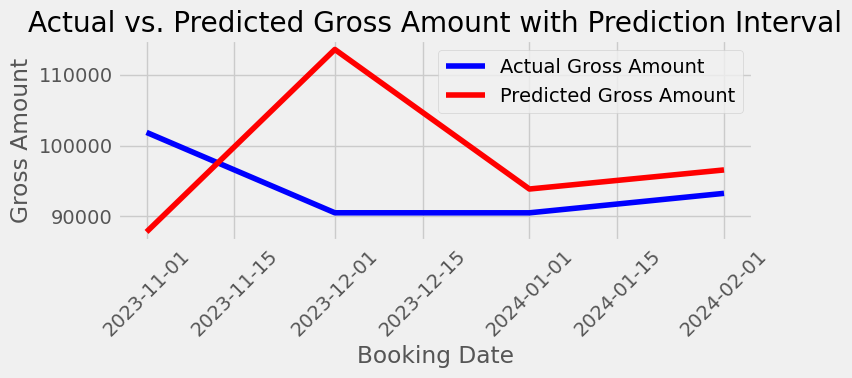

Smape :  11.12537683091185
r2 :  -7.6652891193506
mape :  11.620735756792142


In [75]:

# Plot
plt.figure(figsize=(8, 4))
plt.plot(ac_pdcc['year_month'], ac_pdcc['total_gross_amount'], label='Actual Gross Amount', color='blue')
plt.plot(monthly_sum_df_pdcc['year_month'], monthly_sum_df_pdcc['total_gross_amount'], label='Predicted Gross Amount', color='red')
# plt.fill_between(result_df['year_month'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
plt.xlabel('Booking Date')
plt.ylabel('Gross Amount')
plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

r2 = r2_score(ac_pdcc['total_gross_amount'].values, monthly_sum_df_pdcc['total_gross_amount'].values)
mape = mean_absolute_percentage_error(ac_pdcc['total_gross_amount'].values, monthly_sum_df_pdcc['total_gross_amount'].values)
smape = calculate_smape(ac_pdcc['total_gross_amount'].values, monthly_sum_df_pdcc['total_gross_amount'].values)
print('Smape : ',smape)
print('r2 : ',r2)
print('mape : ',mape)

In [41]:
smape = calculate_smape(ac_pdcc['total_gross_amount'].values, monthly_sum_df_pdcc['total_gross_amount'].values)
print('smape',smape)

smape 27.645383553329438


In [40]:
monthly_sum_df_pdcc['total_gross_amount'].values

array([467784.74117806, 788558.69393929, 474257.48272458, 557817.66378457])

In [ ]:
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import io
doc = Document()

results_list = []



for i in unique_ids:
    try:
        df_filtered = filtered_df[(filtered_df['uniqueID'] == i)]
        df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
        df_filtered.set_index('booking_date', inplace=True)
        df_filtered = df_filtered.resample('D').sum()
        df_filtered.reset_index('booking_date',inplace=True)
        last_booking_date = df_filtered['booking_date'].max()
        date_range = pd.date_range(start=last_booking_date + pd.DateOffset(days=1), end='2024-02-29')
        missing_dates_df = pd.DataFrame({'booking_date': date_range, 'gross_amount': 0,'property_name':0,'new_categoryId':0, 'Supplier':0, 'unique_id':0})
        filled_df = pd.concat([df_filtered, missing_dates_df])
        filled_df = filled_df.sort_values('booking_date')
        df_filtered=filled_df.copy()
        df_filtered = df_filtered.set_index('booking_date')

        df_filtered = df_filtered[['gross_amount']]
#         df_filtered = df_filtered.resample('M').sum()


        sunday_dates = []

        def week_of_month(dt):
            """ Returns the week of the month for the specified date.
            """

            first_day = dt.replace(day=1)

            dom = dt.day
            adjusted_dom = dom + first_day.weekday()

            return int(ceil(adjusted_dom/7.0))


        def add_date_columns(df):
            df['booking_date'] = df.index
            # Add year, month, and week number columns
            df['Year'] = df['booking_date'].dt.year
            df['Month'] = df['booking_date'].dt.month
            df['Week_Number'] = df['booking_date'].apply(lambda x: week_of_month(x))

        def calculate_sunday_date(year, month, week_number):
            # Find the first day of the month
            first_day_of_month = pd.Timestamp(year, month, 1)
            # Calculate the weekday of the first day of the month (0: Monday, 6: Sunday)
            first_day_of_month_weekday = first_day_of_month.dayofweek
            # Calculate the number of days to the next Sunday
            days_to_sunday = 6 - first_day_of_month_weekday
            # Calculate the date of the first Sunday of the month
            first_sunday_of_month = first_day_of_month + pd.Timedelta(days=days_to_sunday)
            # Calculate the date of the Sunday corresponding to the specified week number
            sunday_date = first_sunday_of_month + pd.Timedelta(weeks=week_number - 1)
            return sunday_date


        add_date_columns(df_filtered)    

        df_weekly = df_filtered.groupby(['Year', 'Month', 'Week_Number']).agg({'gross_amount': 'sum'}).reset_index()

        grouped = df_weekly.groupby(['Year', 'Month'])

        # Iterate over each group
        for name, group in grouped:
            last_two_weeks = group.tail(2)
            last_day_of_month = calendar.monthrange(name[0], name[1])[1]
            weekday_of_last_day = calendar.weekday(name[0], name[1], last_day_of_month)
            # Check if the last day of the month is Sunday
            if weekday_of_last_day == 6:  # Sunday
                continue  # If the last day of the month is Sunday, skip summing the last two weeks
            else:
                sum_last_two_weeks = last_two_weeks['gross_amount'].sum()
                min_week_number = min(last_two_weeks['Week_Number'])
                df_weekly.loc[last_two_weeks.index, 'gross_amount'] = sum_last_two_weeks
                df_weekly.loc[last_two_weeks.index, 'Week_Number'] = min_week_number

        df_weekly = df_weekly.drop_duplicates()


        for index, row in df_weekly.iterrows():
            sunday_date = calculate_sunday_date(row['Year'].astype(int), row['Month'].astype(int), row['Week_Number'].astype(int))
            sunday_dates.append(sunday_date)

        df_weekly['Sunday_Date'] = sunday_dates

        columns_to_select = ['Sunday_Date', 'gross_amount']
        df_weekly = df_weekly[columns_to_select].copy()

        df_weekly = df_weekly.rename(columns={'Sunday_Date':'booking_date'})



    #     new_df = df_filtered.copy()
        new_df = df_weekly.copy()
        new_df['Year'] = new_df['booking_date'].dt.year
        new_df['Month'] = new_df['booking_date'].dt.month
        new_df['Week_Number'] = new_df['booking_date'].apply(lambda x: week_of_month(x))
    #     new_df['lag_1'] = new_df['gross_amount'].shift(1)
    #     new_df['lag_2'] = new_df['gross_amount'].shift(2)
    #     new_df['lag_3'] = new_df['gross_amount'].shift(3)
#         new_df['lag_4'] = new_df['gross_amount'].shift(4)
#         new_df['Rolling_SD'] = new_df['gross_amount'].rolling(window=4).std()
        new_df.set_index('booking_date',inplace=True)
        new_df = new_df.dropna()

        train_dataset_end=datetime(2023,10,31)
        test_dataset_end=datetime(2024,2,29)

        train_data=new_df[:train_dataset_end]
        test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

    #     pjme_train_prophet = train_data.reset_index().rename(columns={'booking_date':'ds',
    #                      'gross_amount':'y'})

        train_data = train_data.reset_index()
        prophet_df = train_data.rename(columns={'booking_date': 'ds', 'gross_amount': 'y'})
    #     prophet_df = prophet_df.drop(columns={'property_name','CategoryID','Supplier','unique_id'})

        model = Prophet(interval_width = 0.8)
    #     model.add_country_holidays(country_name='AE')
    #     model.add_regressor('lag_1')
    #     model.add_regressor('lag_2')
    #     model.add_regressor('lag_3')
        # model.add_regressor('Month')
        # model.add_regressor('Week_Number')
        # model.add_regressor('Year')
        model.fit(prophet_df)
        test_prophet = test_data
        # test_prophet = test_data.drop(columns={'gross_amount','property_name','CategoryID','Supplier','unique_id'})
        test_prophet = test_prophet.reset_index()
        test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)
        forecast = model.predict(test_prophet)
        forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        forecast.rename(columns={'ds': 'booking_date', 'yhat':'predicted', }, inplace=True)
        # forecast['predicted'], _ = replace_negatives_with_weighted_average(forecast['predicted'])
        test_data = test_data.reset_index()
        merged_df = pd.merge(test_data, forecast, on='booking_date', how='inner')
        merged_df[['booking_date', 'gross_amount', 'yhat_lower', 'yhat_upper', 'predicted']]
        merged_df = merged_df.set_index("booking_date")
        merged_df['predicted'] = merged_df['predicted'].apply(lambda x: max(0, x))
        resampled_data = merged_df[['gross_amount', 'predicted']].resample('M').sum()
        new_df = new_df[['gross_amount']].resample('M').sum()
        resampled_data = resampled_data.reset_index()

        def calculate_80_confidence_interval(x):
            lower_bound = x * 0.9
            upper_bound = x * 1.1
            return lower_bound, upper_bound

        # Apply the function to the 'predicted_total' column and store the result in a new DataFrame
        interval_df = resampled_data.apply(lambda row: pd.Series(calculate_80_confidence_interval(row['predicted'])), axis=1)

        # Rename columns for clarity
        interval_df.columns = ['lower_bound_80%', 'upper_bound_80%']

        # Concatenate the original DataFrame with the DataFrame containing the confidence intervals
        result_df = pd.concat([resampled_data, interval_df], axis=1)


        result_df = result_df.reset_index()

        result_df['booking_date'] = pd.to_datetime(result_df['booking_date'])

        print("combination:",i)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        r2 = r2_score(result_df['gross_amount'], result_df['predicted'])
        mape = mean_absolute_percentage_error(result_df['gross_amount'], result_df['predicted'])
        smape = calculate_smape(result_df['gross_amount'], result_df['predicted'])


        print("MAPE:", mape)
        print("smape:", smape)
        print("R-squared Score:", r2)
        print('MAE:', mean_absolute_error(result_df['gross_amount'], result_df['predicted']))
        print('RMSE:', np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted'])))

        results_list.append({'Combination': i, 'MAPE': mape, 'sMAPE_1': smape, 'R-squared': r2})

         #Writing to Word Document
        # buf = io.BytesIO()
        # plt.figure(figsize=(8, 4))
        # plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        # plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        # plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        # plt.xlabel('Booking Date')
        # plt.ylabel('Gross Amount')
        # plt.title(f'Actual vs. Predicted Gross Amount with Prediction Interval for ID {i}')
        # plt.legend()
        # plt.grid(True)
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.savefig(buf, format='png')
        # plt.close()

        # # Insert plot into the Word document
        # doc.add_paragraph(f'Combination: {i}')
        # doc.add_picture(buf, width=Inches(6))
        # buf.close()

        # # Write error metrics to the Word document
        # doc.add_paragraph(f"R-squared Score: {r2}")
        # doc.add_paragraph(f"MAPE: {mape}")
        # doc.add_paragraph(f"sMAPE: {smape}")
        # doc.add_paragraph(f"MAE: {mean_absolute_error(result_df['gross_amount'], result_df['predicted'])}")
        # doc.add_paragraph(f"RMSE: {np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted']))}")
        # doc.add_page_break()
    except ValueError as e:
        print(e)
        results_list.append({'Combination': i, 'MAPE': '-', 'sMAPE_1': '-', 'R-squared': '-'})
        pass
# doc.save("P1.docx")
m1 = pd.DataFrame(results_list)
# m1.to_csv('P1.csv', index=False)


## Day to month

# P(2)

In [31]:
unique_ids = [
'55967_H.K. Enterprises L.L.C.',
'62535_Admirals Trading L.L.C.',
'21551_Modern Bakery',
'27994_Khorakiwala & Al Basti L.L.C.',
'55967_M.H. Enterprises LLC',
'46911_M.H. Enterprises LLC',
'19699_Khorakiwala & Al Basti L.L.C.',
'14985_M.H. Enterprises LLC',
'14985_Barakat Vegetables & Fruits Company LLC',
'14985_Modhvadia General Trading LLC',
'27994_Truebell Marketing and Trading LLC - UAE',
'67231_M.H. Enterprises LLC',
'32452_Hasanat Trading Co LLC',
'55298_Alliance Foods Company LLC',
'95556_Bin Hilal Enterprises',
'55967_La Patissiere L.L.C.',
'56297_Emirates Snack Food LLC',
'55967_Classic Fine Foodstuff Trading LLC',
'67231_H.K. Enterprises L.L.C.',
'15628_H.K. Enterprises L.L.C.',
'17974_Elfab Co. (L.L.C.)',
'97993_Modern General Trading L.L.C.',
'92955_Diamond Meat Processing Est.',
'95556_Joma Trading Co. L.L.C',

]

C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:47 - cmdstanpy - INFO - Chain [1] start processing
11:42:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 55967_H.K. Enterprises L.L.C.


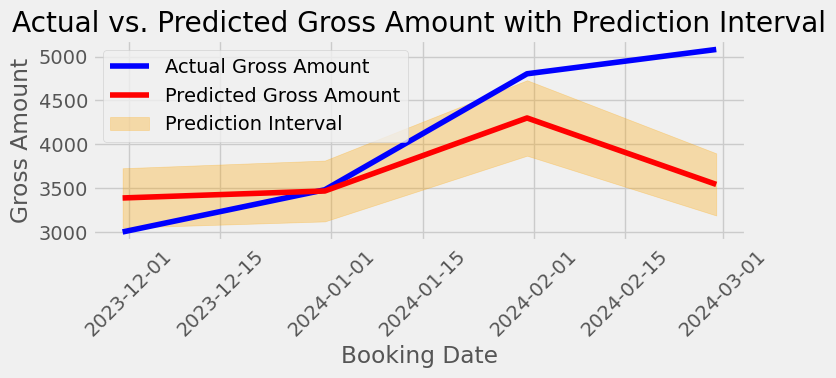

MAPE: 13.514686266106303
smape: 14.8140680204741
R-squared Score: 0.09105449453790848
MAE: 610.7549126085315
RMSE: 832.1362484010564


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:49 - cmdstanpy - INFO - Chain [1] start processing
11:42:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 62535_Admirals Trading L.L.C.


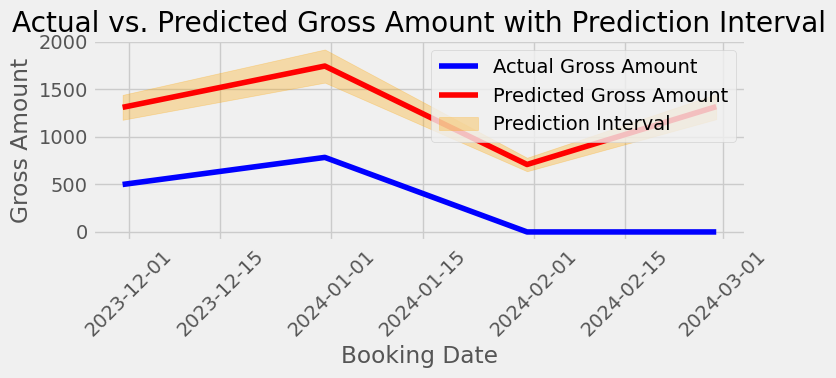

MAPE: inf
smape: 141.40958778243555
R-squared Score: -7.448689919069665
MAE: 950.3175689870438
RMSE: 977.8996472254443


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:52 - cmdstanpy - INFO - Chain [1] start processing
11:42:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 21551_Modern Bakery


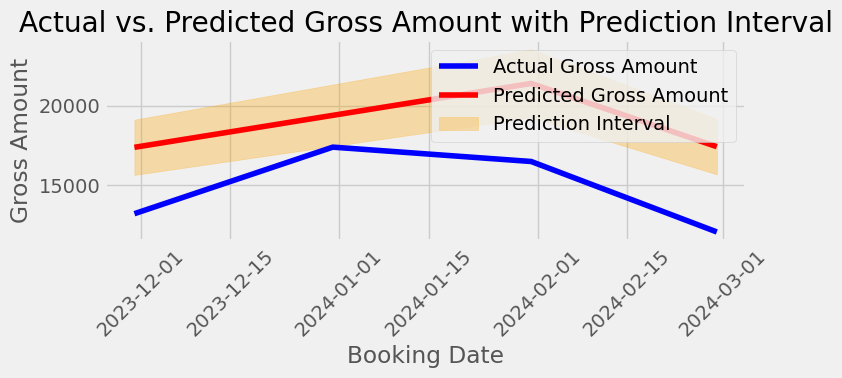

MAPE: 29.37873151612302
smape: 25.145852077948508
R-squared Score: -2.784620393317956
MAE: 4114.899335413957
RMSE: 4312.964469182941


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:54 - cmdstanpy - INFO - Chain [1] start processing
11:42:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 27994_Khorakiwala & Al Basti L.L.C.


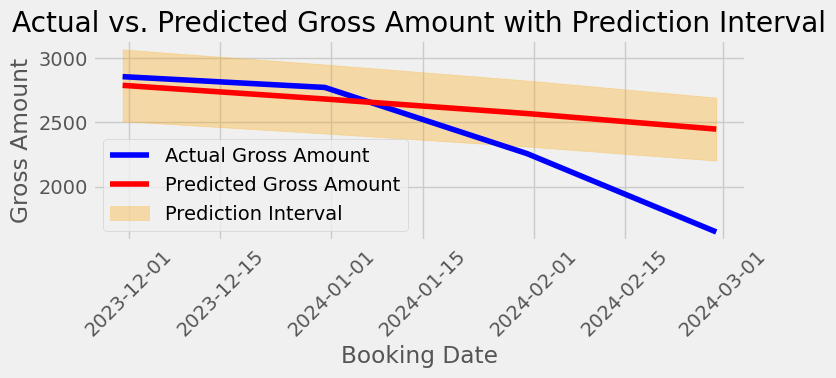

MAPE: 16.977973927320182
smape: 14.40820404104873
R-squared Score: 0.19465264207107946
MAE: 317.1174949361447
RMSE: 432.7834882865844


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:56 - cmdstanpy - INFO - Chain [1] start processing
11:42:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 55967_M.H. Enterprises LLC


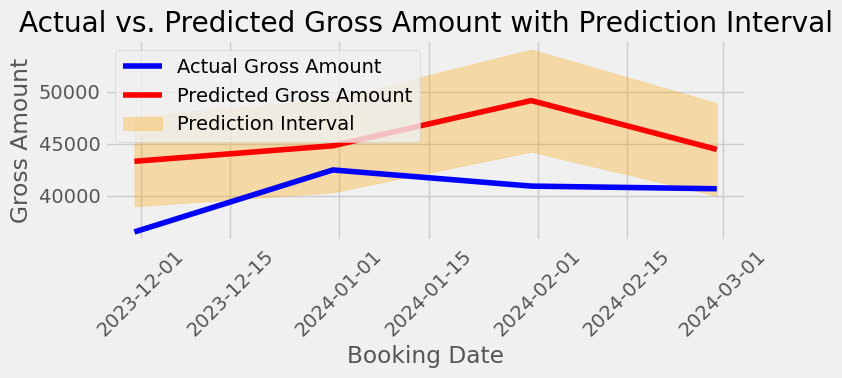

MAPE: 13.362705108841222
smape: 12.369337283266058
R-squared Score: -5.847185492469657
MAE: 5281.515901638148
RMSE: 5777.06083162655


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 46911_M.H. Enterprises LLC


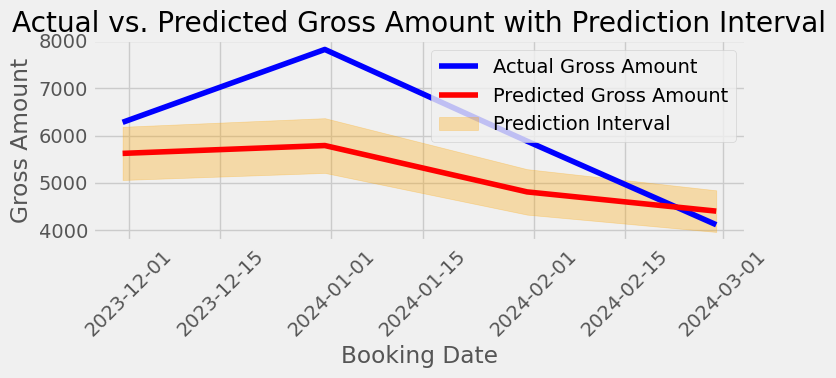

MAPE: 15.420954706271846
smape: 16.933591112591557
R-squared Score: 0.1676762354167174
MAE: 1012.366400325986
RMSE: 1203.4189773795033


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:01 - cmdstanpy - INFO - Chain [1] start processing
11:43:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 19699_Khorakiwala & Al Basti L.L.C.


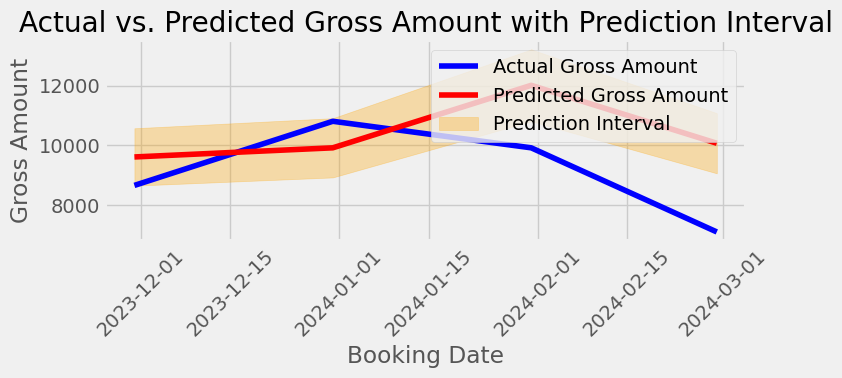

MAPE: 20.53982542524822
smape: 18.1721029838717
R-squared Score: -0.9172287930025895
MAE: 1726.7874827546038
RMSE: 1930.7706412104142


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:03 - cmdstanpy - INFO - Chain [1] start processing
11:43:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 14985_M.H. Enterprises LLC


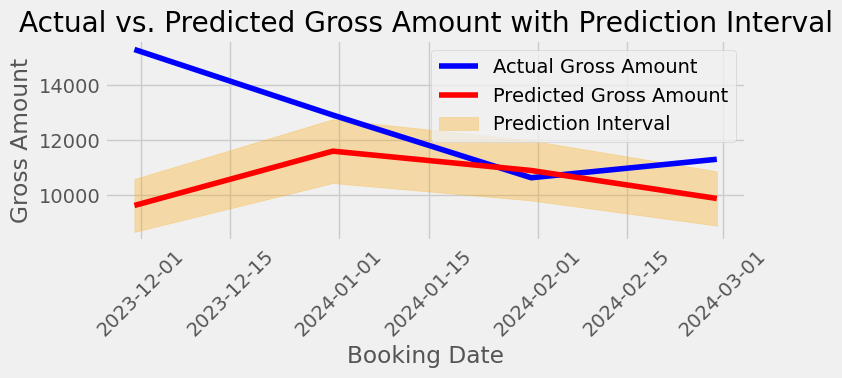

MAPE: 15.57790028774327
smape: 18.027640098520898
R-squared Score: -1.7892931510797214
MAE: 2168.1967394127196
RMSE: 3000.1395534229628


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:05 - cmdstanpy - INFO - Chain [1] start processing
11:43:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 14985_Barakat Vegetables & Fruits Company LLC


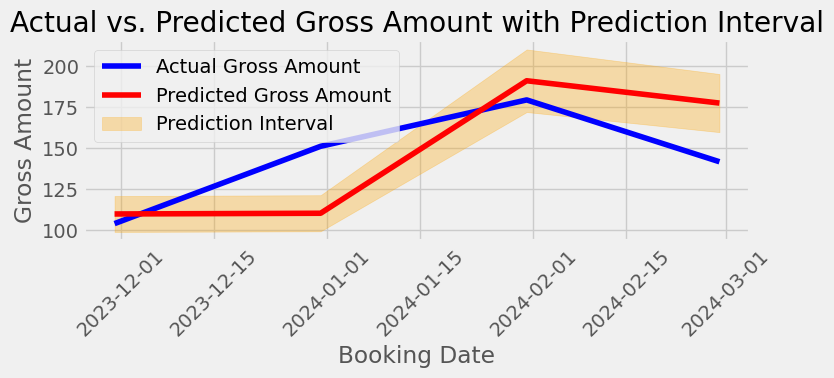

MAPE: 16.137672595989894
smape: 16.39584114235854
R-squared Score: -0.07122803732933303
MAE: 23.596185684808514
RMSE: 27.986489794488293


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:07 - cmdstanpy - INFO - Chain [1] start processing
11:43:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 14985_Modhvadia General Trading LLC


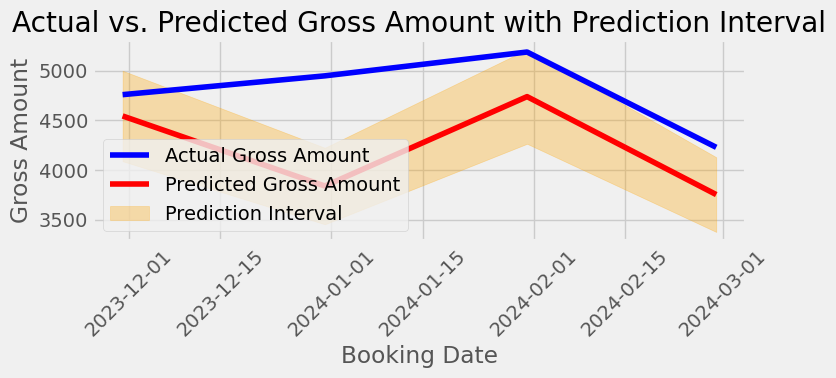

MAPE: 11.686592711374825
smape: 12.681801949087125
R-squared Score: -2.414118853311692
MAE: 561.0893065491865
RMSE: 651.5424801567414


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 27994_Truebell Marketing and Trading LLC - UAE


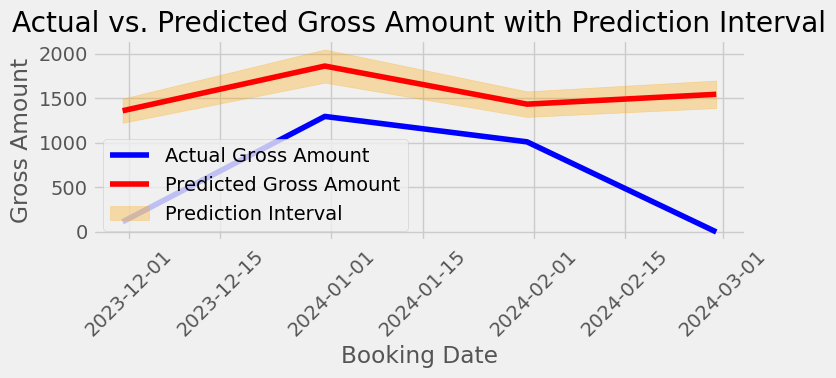

MAPE: inf
smape: 109.87321161687397
R-squared Score: -2.5507411388536387
MAE: 944.4658545831512
RMSE: 1052.8635480730777


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 67231_M.H. Enterprises LLC


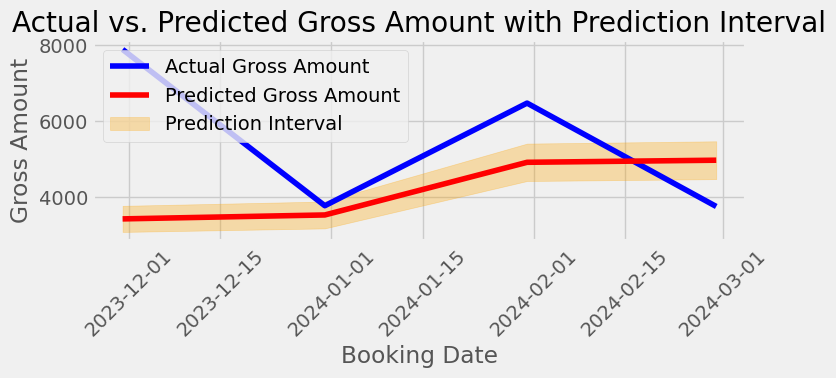

MAPE: 29.825041032525725
smape: 35.12977360531293
R-squared Score: -0.8826650375801672
MAE: 1867.9791820777637
RMSE: 2440.128993822391


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:13 - cmdstanpy - INFO - Chain [1] start processing
11:43:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 32452_Hasanat Trading Co LLC


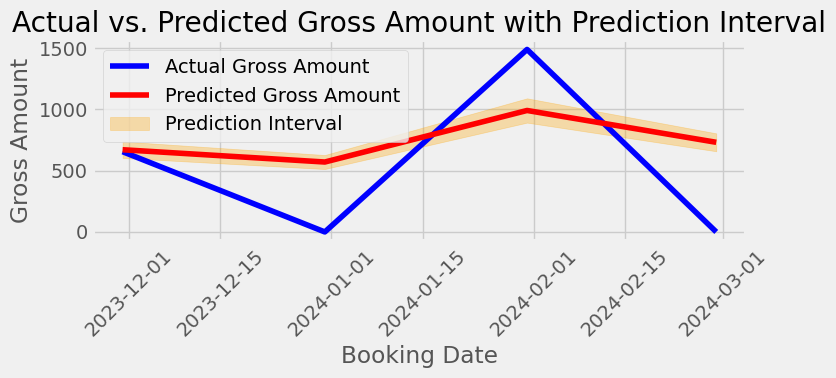

MAPE: inf
smape: 110.63547421940355
R-squared Score: 0.2593532554170096
MAE: 454.11818405612576
RMSE: 526.6824835113433


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:16 - cmdstanpy - INFO - Chain [1] start processing
11:43:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 55298_Alliance Foods Company LLC


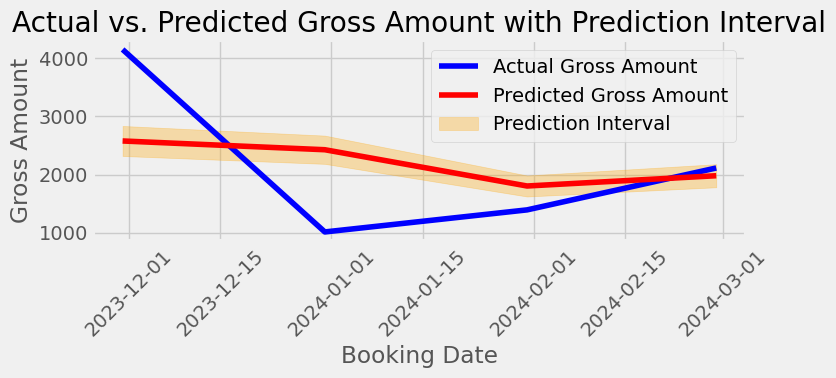

MAPE: 53.174269058460446
smape: 40.23027511310565
R-squared Score: 0.20601511798935834
MAE: 881.97661884255
RMSE: 1078.4948426644296


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:18 - cmdstanpy - INFO - Chain [1] start processing
11:43:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 95556_Bin Hilal Enterprises


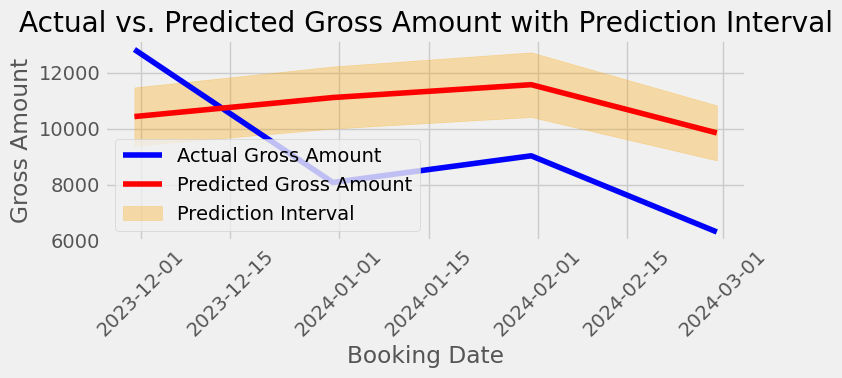

MAPE: 35.249793350744596
smape: 30.270267633115317
R-squared Score: -0.4923019129503172
MAE: 2887.2293115000516
RMSE: 2922.102979346285


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 55967_La Patissiere L.L.C.


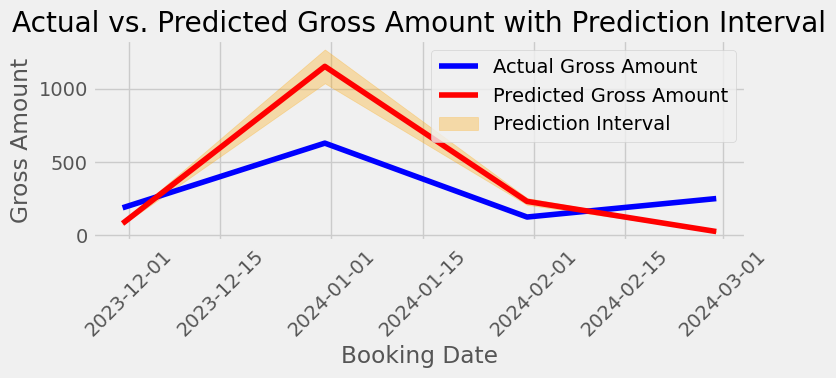

MAPE: 78.42695961535587
smape: 89.64029601101582
R-squared Score: -1.2609987853695457
MAE: 240.60908768740327
RMSE: 294.8469038930858


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:22 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 56297_Emirates Snack Food LLC


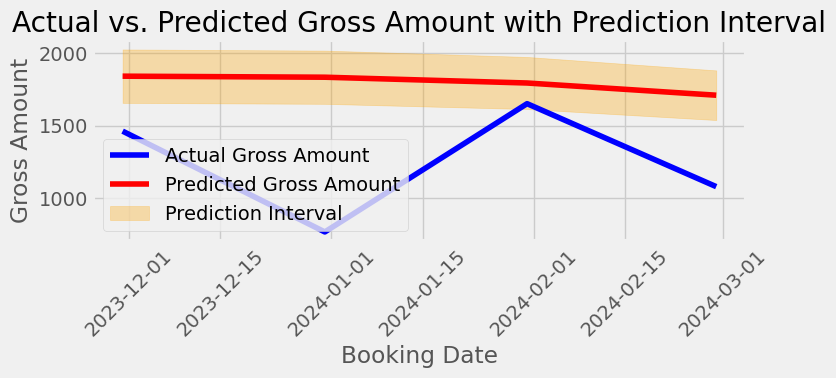

MAPE: 57.924369603467085
smape: 39.57669092612166
R-squared Score: -2.6306568185802424
MAE: 554.8496378945127
RMSE: 652.0216565325304


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:24 - cmdstanpy - INFO - Chain [1] start processing
11:43:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 55967_Classic Fine Foodstuff Trading LLC


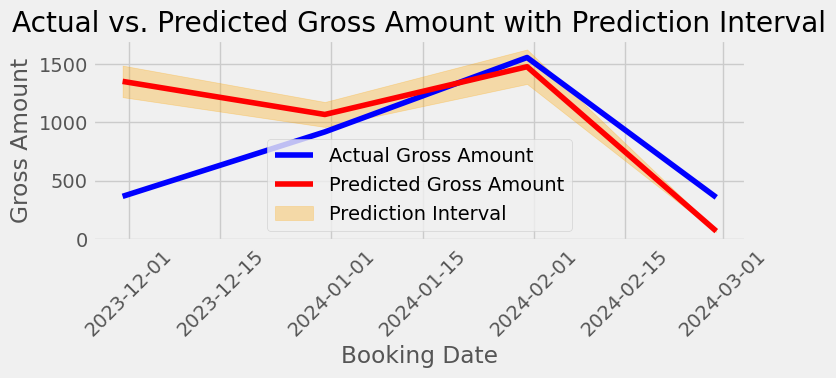

MAPE: 92.47382245406988
smape: 67.4444651203714
R-squared Score: -0.11684577934239493
MAE: 375.39142300301216
RMSE: 519.8748508010347


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:26 - cmdstanpy - INFO - Chain [1] start processing
11:43:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 67231_H.K. Enterprises L.L.C.


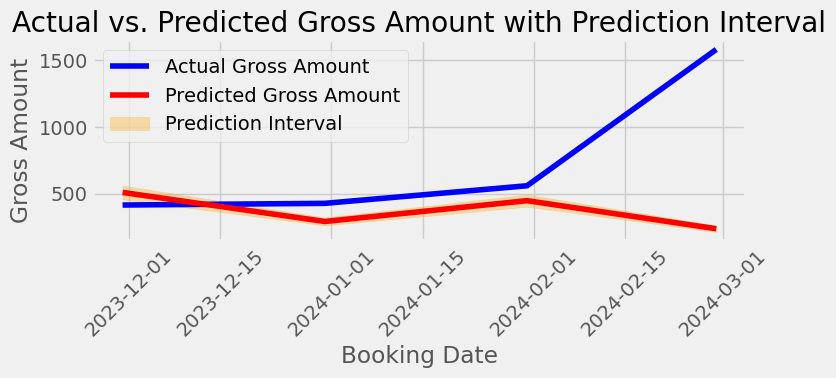

MAPE: 39.738552054299895
smape: 56.82307623430899
R-squared Score: -0.957141218628536
MAE: 421.13229986082916
RMSE: 678.642250127774


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:28 - cmdstanpy - INFO - Chain [1] start processing
11:43:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 15628_H.K. Enterprises L.L.C.


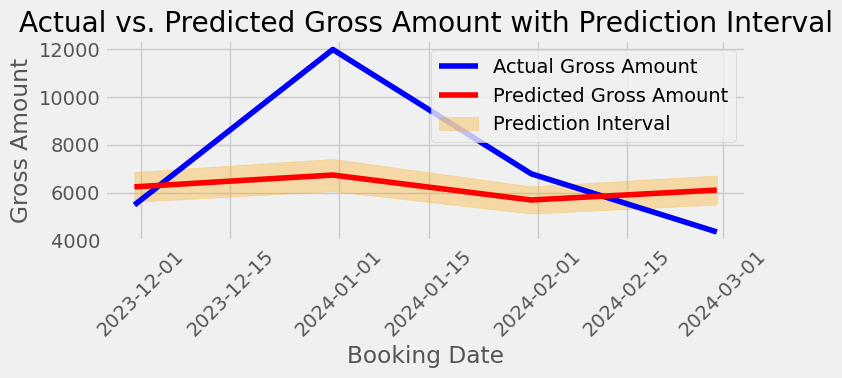

MAPE: 28.528625902826953
smape: 30.048813860458857
R-squared Score: 0.04978584694157129
MAE: 2216.912923217141
RMSE: 2850.447072786254


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 17974_Elfab Co. (L.L.C.)


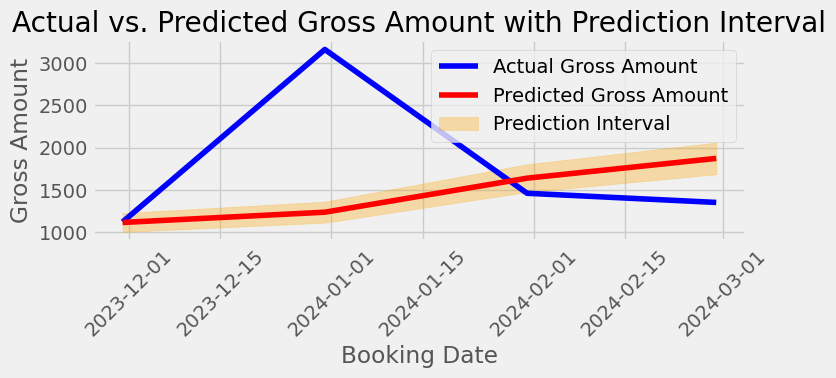

MAPE: 27.97420713528268
smape: 32.89105145875605
R-squared Score: -0.5256310106236264
MAE: 656.3510940736473
RMSE: 999.1395394789196


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:32 - cmdstanpy - INFO - Chain [1] start processing
11:43:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 97993_Modern General Trading L.L.C.


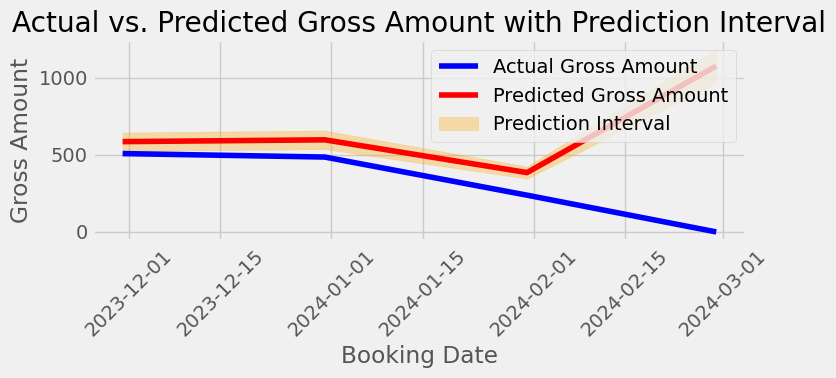

MAPE: inf
smape: 70.45103706852352
R-squared Score: -5.986223199640786
MAE: 352.82126116190636
RMSE: 547.0511793846821


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:34 - cmdstanpy - INFO - Chain [1] start processing
11:43:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 92955_Diamond Meat Processing Est.


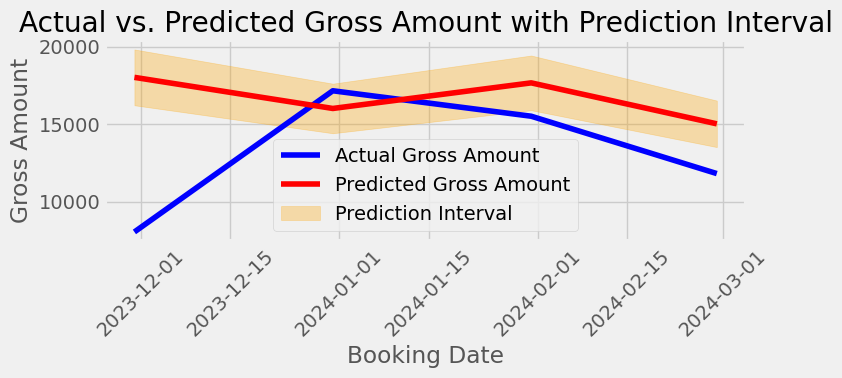

MAPE: 42.99217403528574
smape: 30.113060489867387
R-squared Score: -1.3395913218602384
MAE: 4126.582563766847
RMSE: 5387.977933853875


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:36 - cmdstanpy - INFO - Chain [1] start processing
11:43:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\207748125

combination: 95556_Joma Trading Co. L.L.C


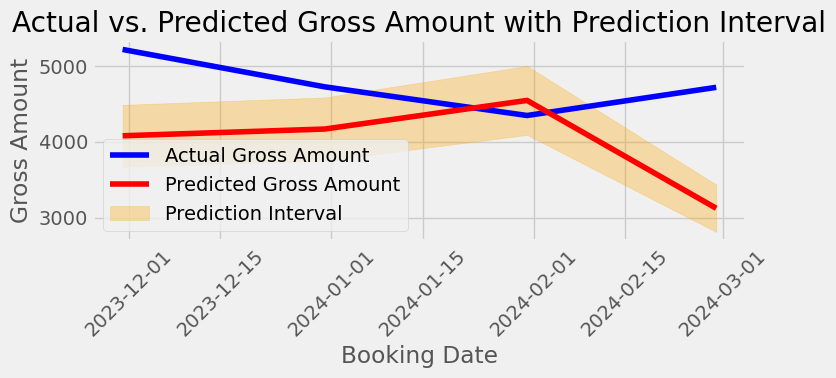

MAPE: 18.00416850097556
smape: 20.553207347383328
R-squared Score: -9.939678519990071
MAE: 872.7677957587458
RMSE: 1024.1093948535379


In [32]:
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import io
doc = Document()

results_list = []



for i in unique_ids:
    try:
        df_filtered = df[(df['unique_id'] == i)]
        df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
        df_filtered.set_index('booking_date', inplace=True)
        df_filtered = df_filtered.resample('D').sum()
        df_filtered.reset_index('booking_date',inplace=True)
        last_booking_date = df_filtered['booking_date'].max()
        date_range = pd.date_range(start=last_booking_date + pd.DateOffset(days=1), end='2024-02-29')
        missing_dates_df = pd.DataFrame({'booking_date': date_range, 'gross_amount': 0,'property_name':0,'new_categoryId':0, 'Supplier':0, 'unique_id':0})
        filled_df = pd.concat([df_filtered, missing_dates_df])
        filled_df = filled_df.sort_values('booking_date')
        df_filtered=filled_df.copy()
        df_filtered = df_filtered.set_index('booking_date')

        df_filtered = df_filtered[['gross_amount']]
#         df_filtered = df_filtered.resample('M').sum()

        sunday_dates = []

        def week_of_month(dt):
            """ Returns the week of the month for the specified date.
            """

            first_day = dt.replace(day=1)

            dom = dt.day
            adjusted_dom = dom + first_day.weekday()

            return int(ceil(adjusted_dom/7.0))


        def add_date_columns(df):
            df['booking_date'] = df.index
            # Add year, month, and week number columns
            df['Year'] = df['booking_date'].dt.year
            df['Month'] = df['booking_date'].dt.month
            df['Week_Number'] = df['booking_date'].apply(lambda x: week_of_month(x))

        def calculate_sunday_date(year, month, week_number):
            # Find the first day of the month
            first_day_of_month = pd.Timestamp(year, month, 1)
            # Calculate the weekday of the first day of the month (0: Monday, 6: Sunday)
            first_day_of_month_weekday = first_day_of_month.dayofweek
            # Calculate the number of days to the next Sunday
            days_to_sunday = 6 - first_day_of_month_weekday
            # Calculate the date of the first Sunday of the month
            first_sunday_of_month = first_day_of_month + pd.Timedelta(days=days_to_sunday)
            # Calculate the date of the Sunday corresponding to the specified week number
            sunday_date = first_sunday_of_month + pd.Timedelta(weeks=week_number - 1)
            return sunday_date


        add_date_columns(df_filtered)    

        df_weekly = df_filtered.groupby(['Year', 'Month', 'Week_Number']).agg({'gross_amount': 'sum'}).reset_index()

        grouped = df_weekly.groupby(['Year', 'Month'])

        # Iterate over each group
        for name, group in grouped:
            last_two_weeks = group.tail(2)
            last_day_of_month = calendar.monthrange(name[0], name[1])[1]
            weekday_of_last_day = calendar.weekday(name[0], name[1], last_day_of_month)
            # Check if the last day of the month is Sunday
            if weekday_of_last_day == 6:  # Sunday
                continue  # If the last day of the month is Sunday, skip summing the last two weeks
            else:
                sum_last_two_weeks = last_two_weeks['gross_amount'].sum()
                min_week_number = min(last_two_weeks['Week_Number'])
                df_weekly.loc[last_two_weeks.index, 'gross_amount'] = sum_last_two_weeks
                df_weekly.loc[last_two_weeks.index, 'Week_Number'] = min_week_number

        df_weekly = df_weekly.drop_duplicates()


        for index, row in df_weekly.iterrows():
            sunday_date = calculate_sunday_date(row['Year'].astype(int), row['Month'].astype(int), row['Week_Number'].astype(int))
            sunday_dates.append(sunday_date)

        df_weekly['Sunday_Date'] = sunday_dates

        columns_to_select = ['Sunday_Date', 'gross_amount']
        df_weekly = df_weekly[columns_to_select].copy()

        df_weekly = df_weekly.rename(columns={'Sunday_Date':'booking_date'})



        new_df = df_filtered.copy()
        # new_df.reset_index('booking_date',inplace=True)
        # new_df = df_weekly.copy()
        new_df['Year'] = new_df['booking_date'].dt.year
        new_df['Month'] = new_df['booking_date'].dt.month
        new_df['Week_Number'] = new_df['booking_date'].apply(lambda x: week_of_month(x))
    #     new_df['lag_1'] = new_df['gross_amount'].shift(1)
    #     new_df['lag_2'] = new_df['gross_amount'].shift(2)
    #     new_df['lag_3'] = new_df['gross_amount'].shift(3)
#         new_df['lag_4'] = new_df['gross_amount'].shift(4)
#         new_df['Rolling_SD'] = new_df['gross_amount'].rolling(window=4).std()
        # new_df.set_index('booking_date',inplace=True)
        new_df = new_df.dropna()

        train_dataset_end=datetime(2023,10,31)
        test_dataset_end=datetime(2024,2,29)

        train_data=new_df[:train_dataset_end]
        test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

    #     pjme_train_prophet = train_data.reset_index().rename(columns={'booking_date':'ds',
    #                      'gross_amount':'y'})

        # train_data = train_data.reset_index()
        prophet_df = train_data.rename(columns={'booking_date': 'ds', 'gross_amount': 'y'})
    #     prophet_df = prophet_df.drop(columns={'property_name','CategoryID','Supplier','unique_id'})

        model = Prophet(interval_width = 0.8)
        model.add_country_holidays(country_name='AE')
    #     model.add_regressor('lag_1')
    #     model.add_regressor('lag_2')
    #     model.add_regressor('lag_3')
        model.add_regressor('Month')
        model.add_regressor('Week_Number')
        model.add_regressor('Year')
        model.fit(prophet_df)
        test_prophet = test_data
        # test_prophet = test_data.drop(columns={'gross_amount','property_name','CategoryID','Supplier','unique_id'})
        # test_prophet = test_prophet.reset_index()
        test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)
        forecast = model.predict(test_prophet)
        forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        forecast.rename(columns={'ds': 'booking_date', 'yhat':'predicted', }, inplace=True)
        test_data = test_data.reset_index()
        merged_df = pd.merge(test_data, forecast, on='booking_date', how='inner')
        merged_df[['booking_date', 'gross_amount', 'yhat_lower', 'yhat_upper', 'predicted']]
        merged_df = merged_df.set_index("booking_date")
        merged_df['predicted'] = merged_df['predicted'].apply(lambda x: max(0, x))
        resampled_data = merged_df[['gross_amount', 'predicted']].resample('M').sum()
        new_df = new_df[['gross_amount']].resample('M').sum()
        resampled_data = resampled_data.reset_index()

        def calculate_80_confidence_interval(x):
            lower_bound = x * 0.9
            upper_bound = x * 1.1
            return lower_bound, upper_bound

        # Apply the function to the 'predicted_total' column and store the result in a new DataFrame
        interval_df = resampled_data.apply(lambda row: pd.Series(calculate_80_confidence_interval(row['predicted'])), axis=1)

        # Rename columns for clarity
        interval_df.columns = ['lower_bound_80%', 'upper_bound_80%']

        # Concatenate the original DataFrame with the DataFrame containing the confidence intervals
        result_df = pd.concat([resampled_data, interval_df], axis=1)


        result_df = result_df.reset_index()

        result_df['booking_date'] = pd.to_datetime(result_df['booking_date'])

        print("combination:",i)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        r2 = r2_score(result_df['gross_amount'], result_df['predicted'])
        mape = mean_absolute_percentage_error(result_df['gross_amount'], result_df['predicted'])
        smape = calculate_smape(result_df['gross_amount'], result_df['predicted'])


        print("MAPE:", mape)
        print("smape:", smape)
        print("R-squared Score:", r2)
        print('MAE:', mean_absolute_error(result_df['gross_amount'], result_df['predicted']))
        print('RMSE:', np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted'])))

        results_list.append({'Combination': i, 'MAPE': mape, 'sMAPE_2': smape, 'R-squared': r2})

         #Writing to Word Document
        buf = io.BytesIO()
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title(f'Actual vs. Predicted Gross Amount with Prediction Interval for ID {i}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(buf, format='png')
        plt.close()

        # Insert plot into the Word document
        doc.add_paragraph(f'Combination: {i}')
        doc.add_picture(buf, width=Inches(6))
        buf.close()

        # Write error metrics to the Word document
        doc.add_paragraph(f"R-squared Score: {r2}")
        doc.add_paragraph(f"MAPE: {mape}")
        doc.add_paragraph(f"sMAPE: {smape}")
        doc.add_paragraph(f"MAE: {mean_absolute_error(result_df['gross_amount'], result_df['predicted'])}")
        doc.add_paragraph(f"RMSE: {np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted']))}")
        doc.add_page_break()
    except ValueError as e:
        print(e)
        results_list.append({'Combination': i, 'MAPE': '-', 'sMAPE_2': '-', 'R-squared': '-'})
        pass
# doc.save("P2.docx")
m2 = pd.DataFrame(results_list)
# m2.to_csv('P2.csv', index=False)


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:39 - cmdstanpy - INFO - Chain [1] start processing
11:43:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 55967_H.K. Enterprises L.L.C.


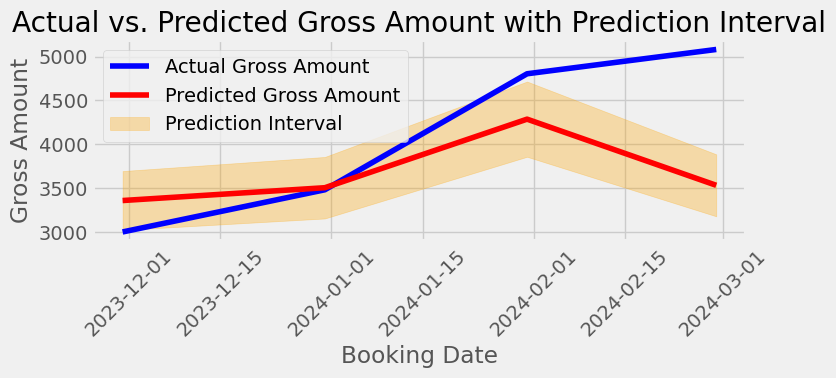

MAPE: 13.460840927339351
smape: 14.814895942409112
R-squared Score: 0.08320473333127698
MAE: 611.7860624974547
RMSE: 835.7217375409924


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 62535_Admirals Trading L.L.C.


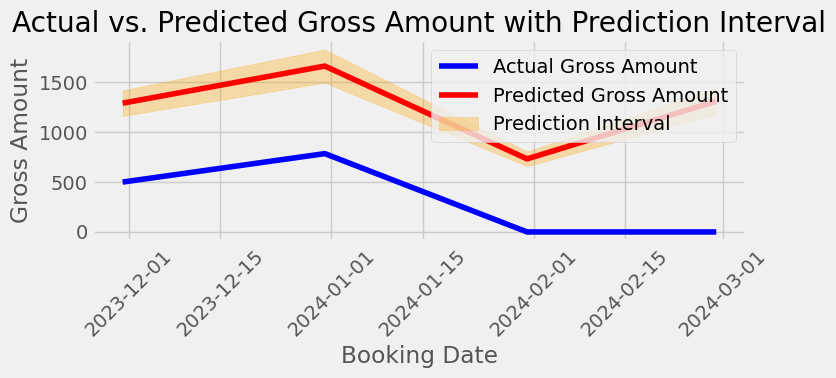

MAPE: inf
smape: 140.00785748510526
R-squared Score: -7.049270109676218
MAE: 927.1253252766157
RMSE: 954.5042238336204


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:42 - cmdstanpy - INFO - Chain [1] start processing
11:43:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 21551_Modern Bakery


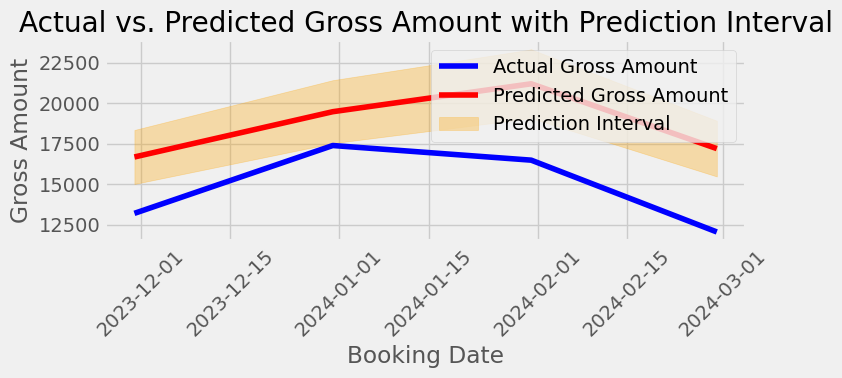

MAPE: 27.433478540846068
smape: 23.719275582549493
R-squared Score: -2.3183298763715063
MAE: 3858.9278211619926
RMSE: 4038.5410008991703


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:44 - cmdstanpy - INFO - Chain [1] start processing
11:43:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 27994_Khorakiwala & Al Basti L.L.C.


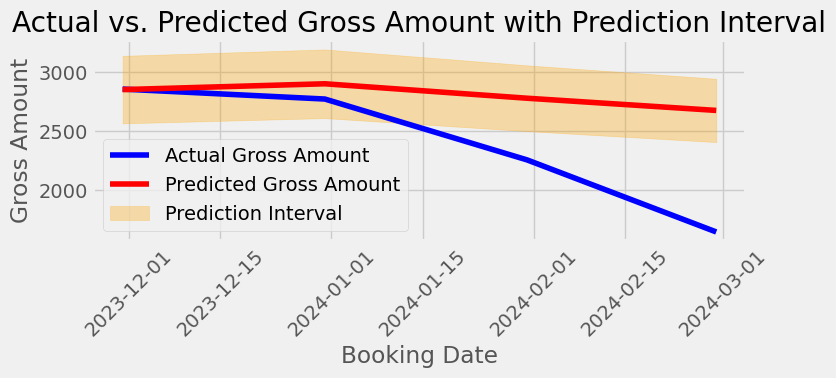

MAPE: 22.55193081462011
smape: 18.22740014358894
R-squared Score: -0.444291978290843
MAE: 420.44958351327557
RMSE: 579.5708891797015


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:46 - cmdstanpy - INFO - Chain [1] start processing
11:43:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 55967_M.H. Enterprises LLC


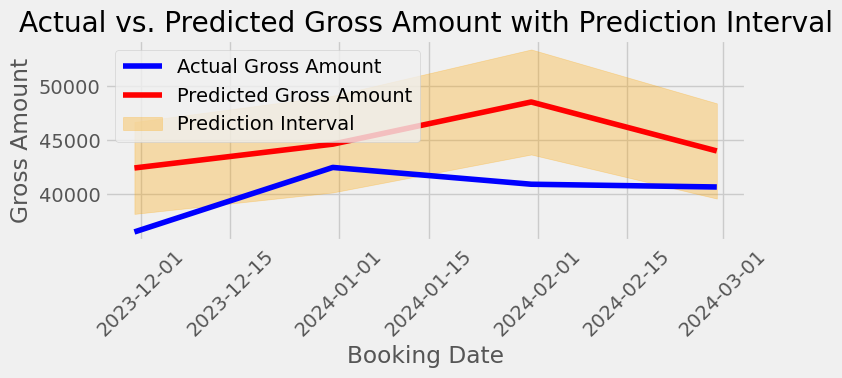

MAPE: 11.99956405360589
smape: 11.190797536065528
R-squared Score: -4.562494221616975
MAE: 4749.092120606025
RMSE: 5206.97725304736


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:48 - cmdstanpy - INFO - Chain [1] start processing
11:43:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 46911_M.H. Enterprises LLC


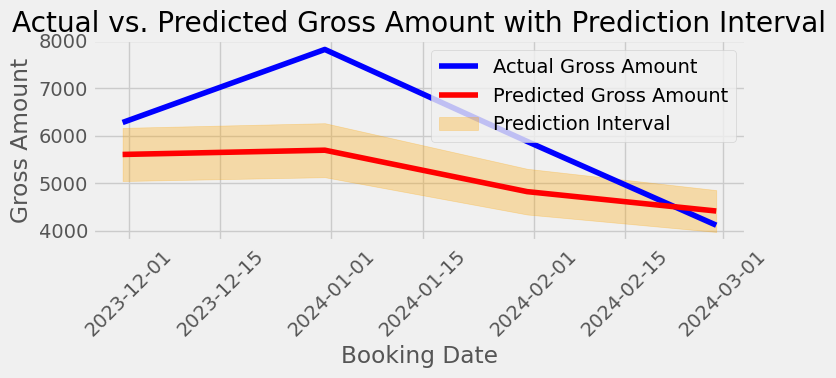

MAPE: 15.79464929891506
smape: 17.39637674310566
R-squared Score: 0.11218747283756492
MAE: 1039.1823179230996
RMSE: 1242.886133550301


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:50 - cmdstanpy - INFO - Chain [1] start processing
11:43:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 19699_Khorakiwala & Al Basti L.L.C.


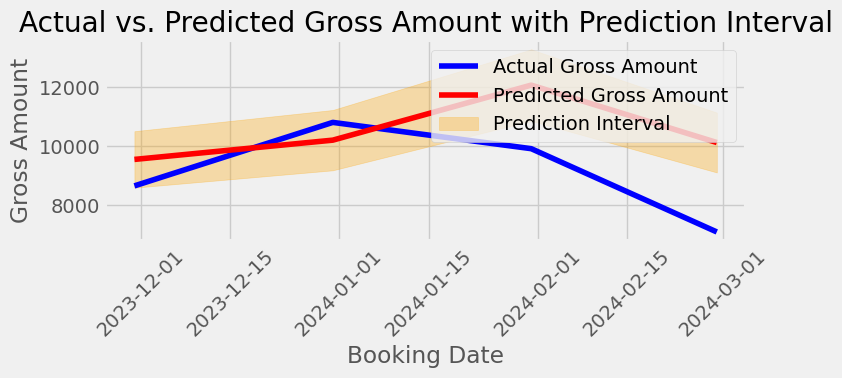

MAPE: 20.043928258362072
smape: 17.555987715330865
R-squared Score: -0.9218716623347096
MAE: 1668.2788730022075
RMSE: 1933.1070590830195


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:52 - cmdstanpy - INFO - Chain [1] start processing
11:43:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 14985_M.H. Enterprises LLC


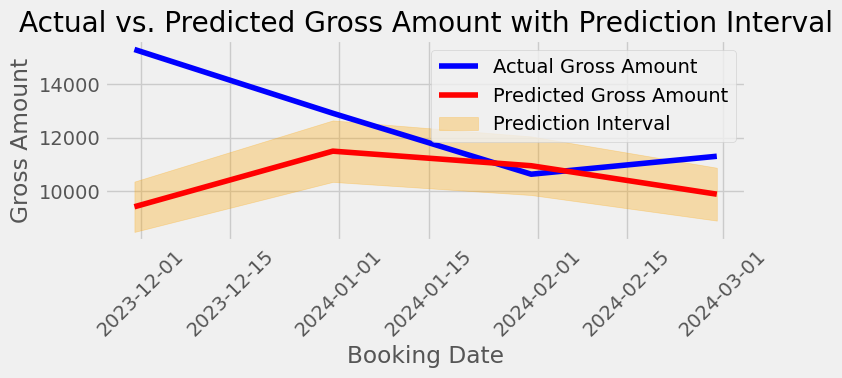

MAPE: 16.23353736292483
smape: 18.878608213266666
R-squared Score: -1.9994685839234956
MAE: 2258.392396819715
RMSE: 3111.118370162687


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:54 - cmdstanpy - INFO - Chain [1] start processing
11:43:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 14985_Barakat Vegetables & Fruits Company LLC


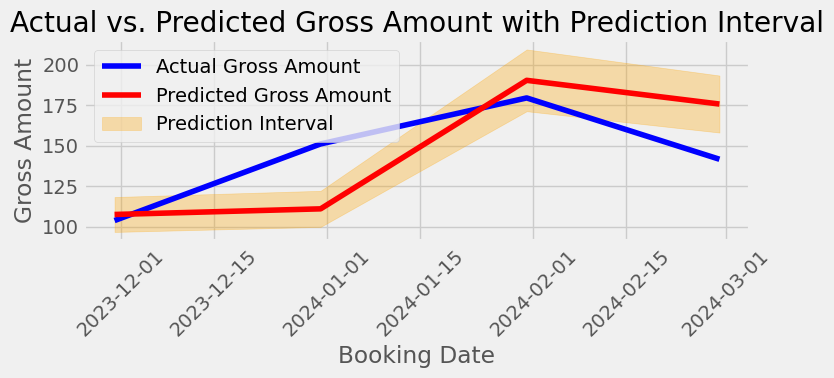

MAPE: 15.03358856268862
smape: 15.339742162214195
R-squared Score: 0.010787332546146278
MAE: 22.16677523386612
RMSE: 26.893807970915915


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:56 - cmdstanpy - INFO - Chain [1] start processing
11:43:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 14985_Modhvadia General Trading LLC


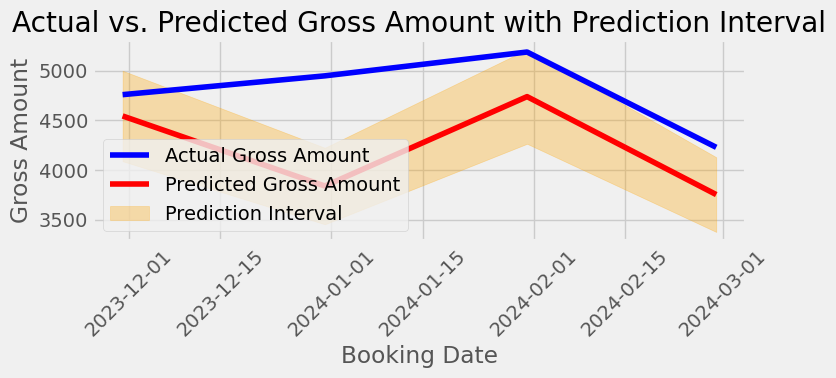

MAPE: 11.686593853466384
smape: 12.681803220271812
R-squared Score: -2.414119295471294
MAE: 561.0893620551313
RMSE: 651.5425223470937


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:58 - cmdstanpy - INFO - Chain [1] start processing
11:43:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 27994_Truebell Marketing and Trading LLC - UAE


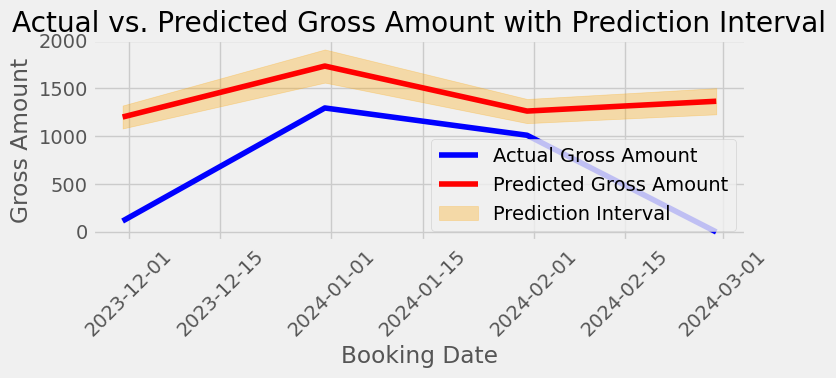

MAPE: inf
smape: 104.12433546662105
R-squared Score: -1.6457003857162933
MAE: 786.0192038025185
RMSE: 908.8305438056777


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:43:59 - cmdstanpy - INFO - Chain [1] start processing
11:44:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 67231_M.H. Enterprises LLC


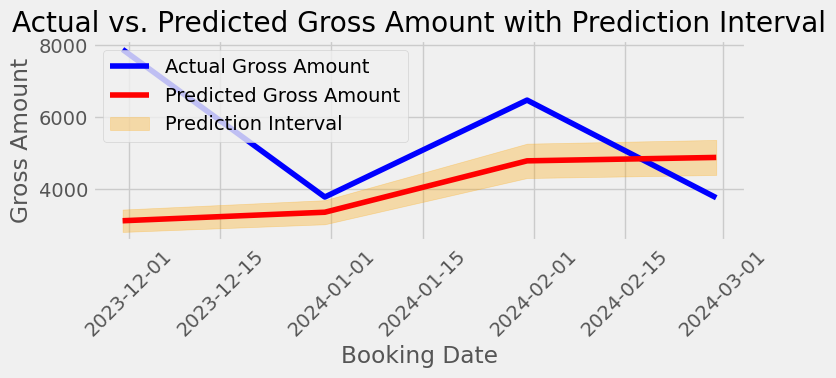

MAPE: 31.908130527655615
smape: 38.63847481382839
R-squared Score: -1.1387389442902314
MAE: 2001.8197498448249
RMSE: 2600.789153645203


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 32452_Hasanat Trading Co LLC


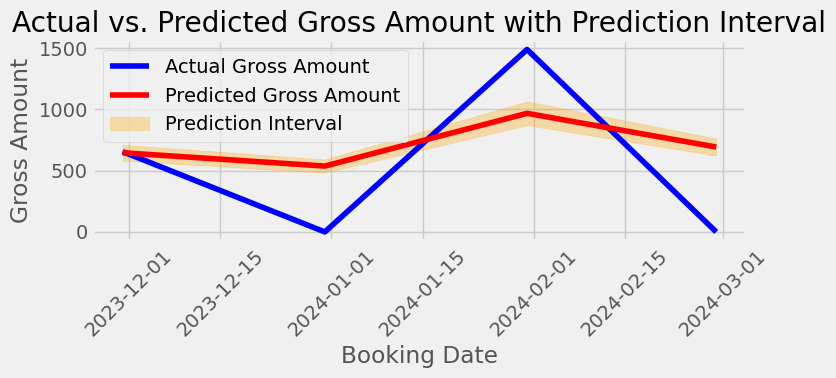

MAPE: inf
smape: 110.93736035645891
R-squared Score: 0.30467451123934475
MAE: 440.2384178361359
RMSE: 510.31389133305254


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 55298_Alliance Foods Company LLC


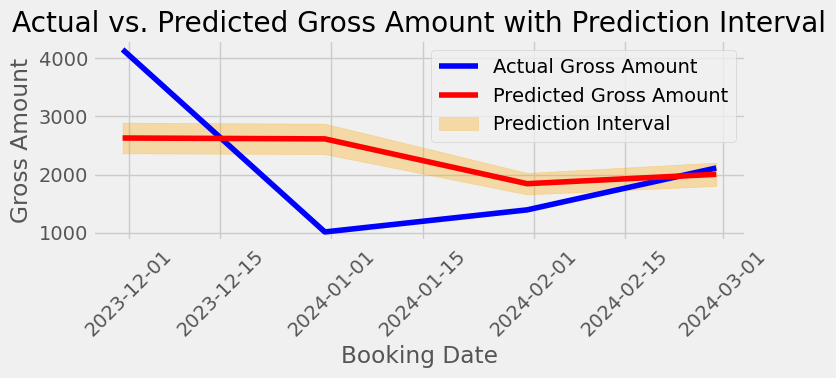

MAPE: 57.87701770351254
smape: 41.504186941377824
R-squared Score: 0.13235563008392315
MAE: 919.5485621418259
RMSE: 1127.4124658920198


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:05 - cmdstanpy - INFO - Chain [1] start processing
11:44:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 95556_Bin Hilal Enterprises


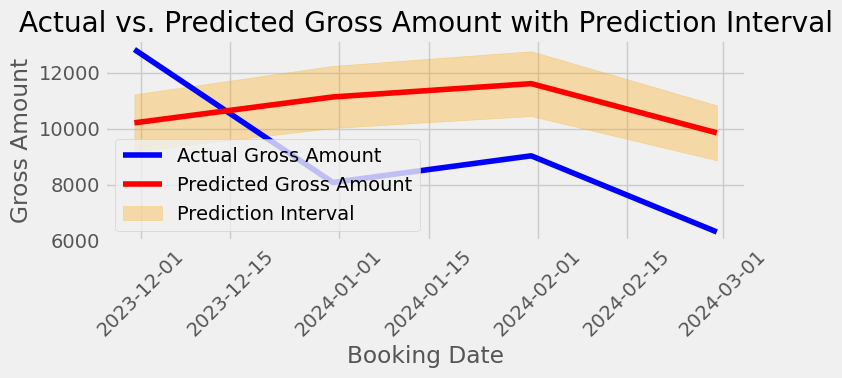

MAPE: 35.8689278726255
smape: 30.941422323045323
R-squared Score: -0.556768827823136
MAE: 2958.864046814565
RMSE: 2984.552567743446


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:07 - cmdstanpy - INFO - Chain [1] start processing
11:44:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 55967_La Patissiere L.L.C.


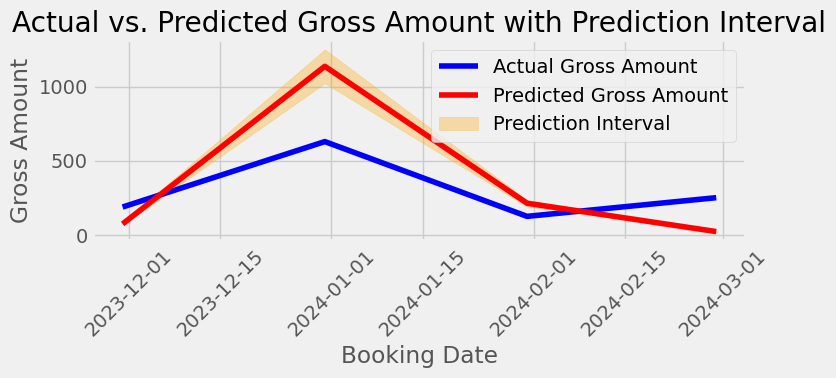

MAPE: 75.43671533281127
smape: 90.45188745119088
R-squared Score: -1.1477201252009408
MAE: 234.5657551309617
RMSE: 287.36591247299503


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:09 - cmdstanpy - INFO - Chain [1] start processing
11:44:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 56297_Emirates Snack Food LLC


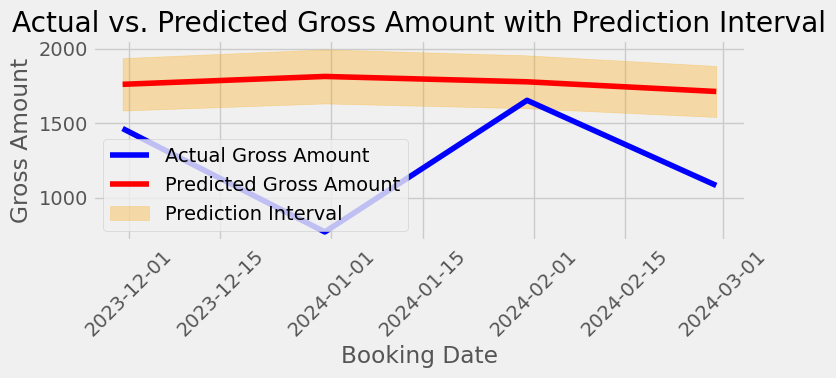

MAPE: 55.56385842252807
smape: 37.96387210466142
R-squared Score: -2.406134263475545
MAE: 524.6372832343966
RMSE: 631.539185077353


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:11 - cmdstanpy - INFO - Chain [1] start processing
11:44:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 55967_Classic Fine Foodstuff Trading LLC


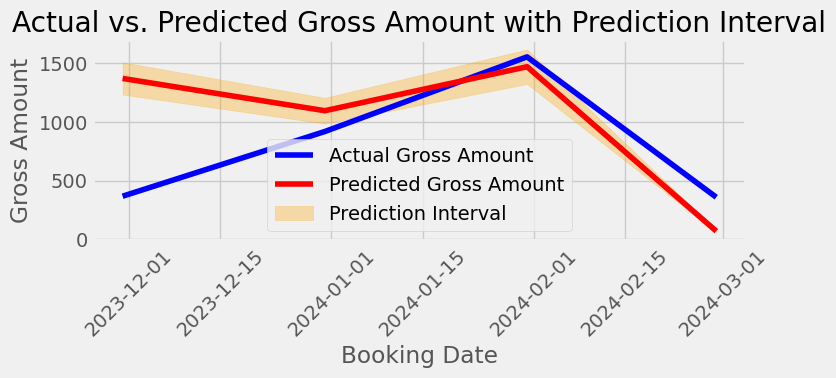

MAPE: 94.73405579033275
smape: 68.474230220567
R-squared Score: -0.1694029988520278
MAE: 388.9431629852188
RMSE: 531.9665278625198


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:12 - cmdstanpy - INFO - Chain [1] start processing
11:44:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 67231_H.K. Enterprises L.L.C.


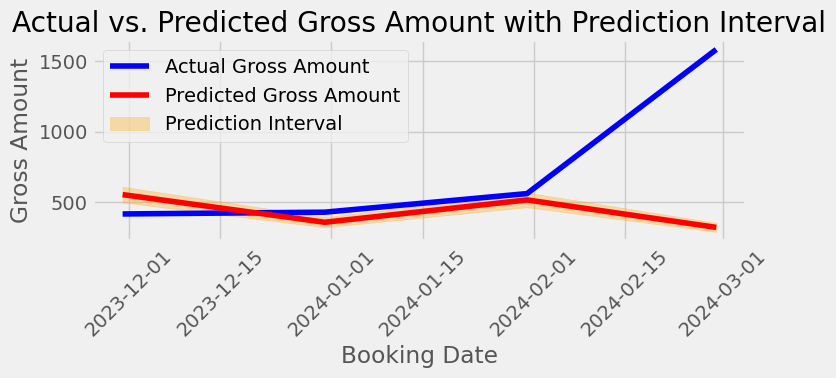

MAPE: 34.279447138018895
smape: 46.753347326998124
R-squared Score: -0.7144542636450661
MAE: 378.41553986309896
RMSE: 635.1740755351263


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:14 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 15628_H.K. Enterprises L.L.C.


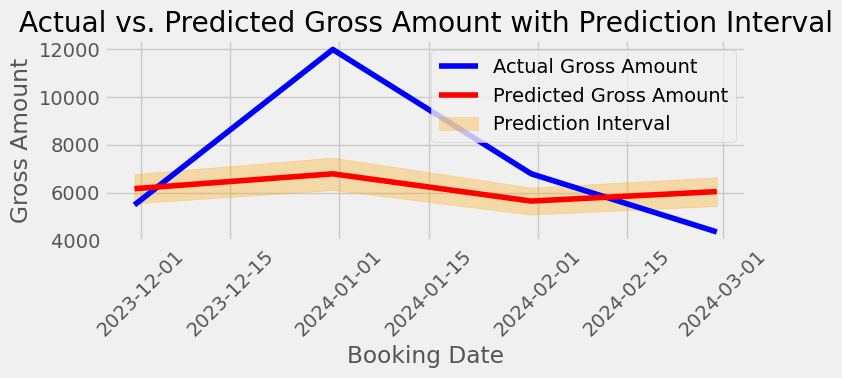

MAPE: 27.87849535768091
smape: 29.515022414614858
R-squared Score: 0.071862454410065
MAE: 2180.702285594546
RMSE: 2817.1398351639846


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:16 - cmdstanpy - INFO - Chain [1] start processing
11:44:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 17974_Elfab Co. (L.L.C.)


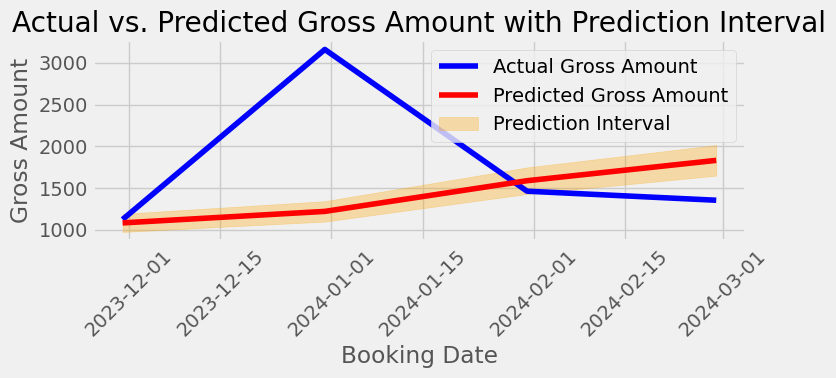

MAPE: 27.21996628035886
smape: 32.619553473586066
R-squared Score: -0.5311994139835481
MAE: 646.0024314445518
RMSE: 1000.9612593162223


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:18 - cmdstanpy - INFO - Chain [1] start processing
11:44:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 97993_Modern General Trading L.L.C.


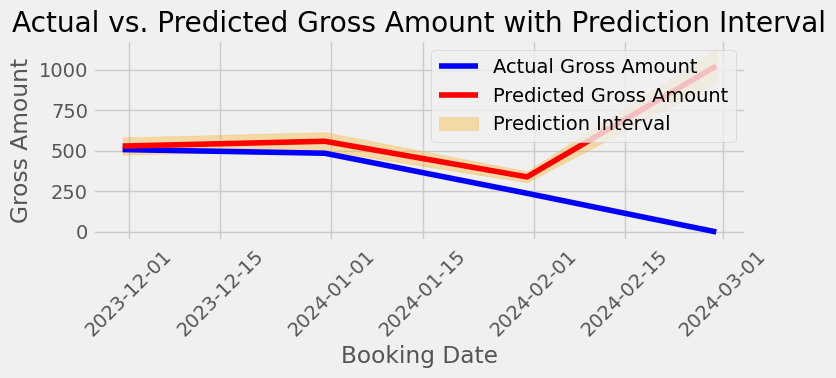

MAPE: inf
smape: 63.326807692096565
R-squared Score: -5.206827559261305
MAE: 304.9957968267455
RMSE: 515.6340285219228


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:20 - cmdstanpy - INFO - Chain [1] start processing
11:44:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 92955_Diamond Meat Processing Est.


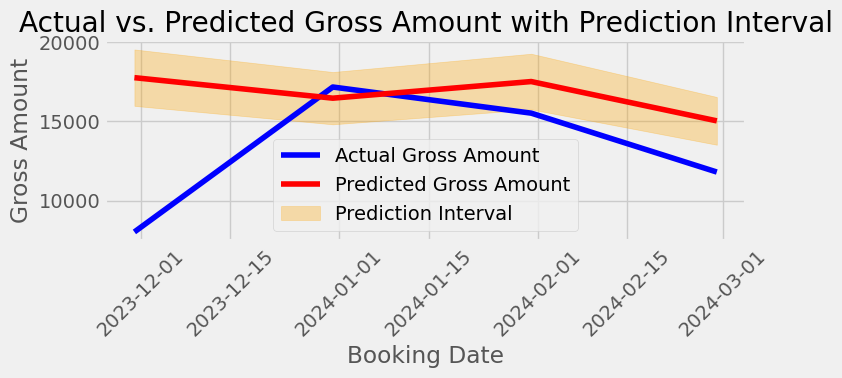

MAPE: 41.228063420882734
smape: 28.874519394468273
R-squared Score: -1.1995838077771976
MAE: 3906.360315444287
RMSE: 5224.275419487069


C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613144.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Sunday_Date'] = sunday_dates
11:44:22 - cmdstanpy - INFO - Chain [1] start processing
11:44:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_16812\2078613

combination: 95556_Joma Trading Co. L.L.C


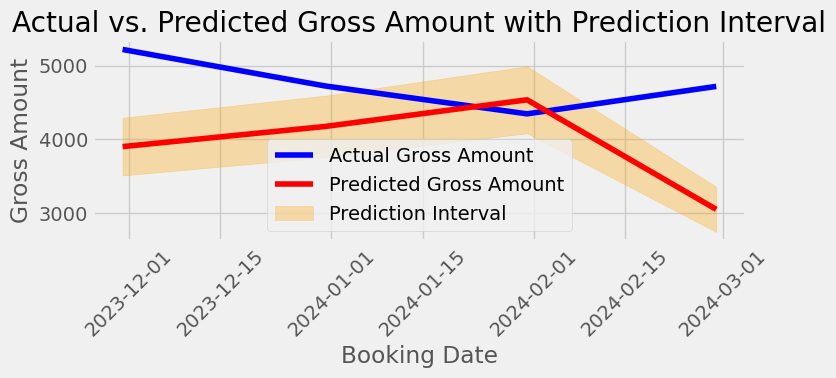

MAPE: 19.11836167840856
smape: 22.071924750045163
R-squared Score: -11.617812219209576
MAE: 929.7474770322641
RMSE: 1099.8566887286834


In [33]:
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import io
doc = Document()

results_list = []



for i in unique_ids:
    try:
        df_filtered = df[(df['unique_id'] == i)]
        df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
        df_filtered.set_index('booking_date', inplace=True)
        df_filtered = df_filtered.resample('D').sum()
        df_filtered.reset_index('booking_date',inplace=True)
        last_booking_date = df_filtered['booking_date'].max()
        date_range = pd.date_range(start=last_booking_date + pd.DateOffset(days=1), end='2024-02-29')
        missing_dates_df = pd.DataFrame({'booking_date': date_range, 'gross_amount': 0,'property_name':0,'new_categoryId':0, 'Supplier':0, 'unique_id':0})
        filled_df = pd.concat([df_filtered, missing_dates_df])
        filled_df = filled_df.sort_values('booking_date')
        df_filtered=filled_df.copy()
        df_filtered = df_filtered.set_index('booking_date')

        df_filtered = df_filtered[['gross_amount']]
#         df_filtered = df_filtered.resample('M').sum()

        sunday_dates = []

        def week_of_month(dt):
            """ Returns the week of the month for the specified date.
            """

            first_day = dt.replace(day=1)

            dom = dt.day
            adjusted_dom = dom + first_day.weekday()

            return int(ceil(adjusted_dom/7.0))


        def add_date_columns(df):
            df['booking_date'] = df.index
            # Add year, month, and week number columns
            df['Year'] = df['booking_date'].dt.year
            df['Month'] = df['booking_date'].dt.month
            df['Week_Number'] = df['booking_date'].apply(lambda x: week_of_month(x))

        def calculate_sunday_date(year, month, week_number):
            # Find the first day of the month
            first_day_of_month = pd.Timestamp(year, month, 1)
            # Calculate the weekday of the first day of the month (0: Monday, 6: Sunday)
            first_day_of_month_weekday = first_day_of_month.dayofweek
            # Calculate the number of days to the next Sunday
            days_to_sunday = 6 - first_day_of_month_weekday
            # Calculate the date of the first Sunday of the month
            first_sunday_of_month = first_day_of_month + pd.Timedelta(days=days_to_sunday)
            # Calculate the date of the Sunday corresponding to the specified week number
            sunday_date = first_sunday_of_month + pd.Timedelta(weeks=week_number - 1)
            return sunday_date


        add_date_columns(df_filtered)    

        df_weekly = df_filtered.groupby(['Year', 'Month', 'Week_Number']).agg({'gross_amount': 'sum'}).reset_index()

        grouped = df_weekly.groupby(['Year', 'Month'])

        # Iterate over each group
        for name, group in grouped:
            last_two_weeks = group.tail(2)
            last_day_of_month = calendar.monthrange(name[0], name[1])[1]
            weekday_of_last_day = calendar.weekday(name[0], name[1], last_day_of_month)
            # Check if the last day of the month is Sunday
            if weekday_of_last_day == 6:  # Sunday
                continue  # If the last day of the month is Sunday, skip summing the last two weeks
            else:
                sum_last_two_weeks = last_two_weeks['gross_amount'].sum()
                min_week_number = min(last_two_weeks['Week_Number'])
                df_weekly.loc[last_two_weeks.index, 'gross_amount'] = sum_last_two_weeks
                df_weekly.loc[last_two_weeks.index, 'Week_Number'] = min_week_number

        df_weekly = df_weekly.drop_duplicates()


        for index, row in df_weekly.iterrows():
            sunday_date = calculate_sunday_date(row['Year'].astype(int), row['Month'].astype(int), row['Week_Number'].astype(int))
            sunday_dates.append(sunday_date)

        df_weekly['Sunday_Date'] = sunday_dates

        columns_to_select = ['Sunday_Date', 'gross_amount']
        df_weekly = df_weekly[columns_to_select].copy()

        df_weekly = df_weekly.rename(columns={'Sunday_Date':'booking_date'})



        new_df = df_filtered.copy()
        # new_df.reset_index('booking_date',inplace=True)
        # new_df = df_weekly.copy()
        new_df['Year'] = new_df['booking_date'].dt.year
        new_df['Month'] = new_df['booking_date'].dt.month
        new_df['Week_Number'] = new_df['booking_date'].apply(lambda x: week_of_month(x))
    #     new_df['lag_1'] = new_df['gross_amount'].shift(1)
    #     new_df['lag_2'] = new_df['gross_amount'].shift(2)
    #     new_df['lag_3'] = new_df['gross_amount'].shift(3)
#         new_df['lag_4'] = new_df['gross_amount'].shift(4)
#         new_df['Rolling_SD'] = new_df['gross_amount'].rolling(window=4).std()
        # new_df.set_index('booking_date',inplace=True)
        new_df = new_df.dropna()

        train_dataset_end=datetime(2023,10,31)
        test_dataset_end=datetime(2024,2,29)

        train_data=new_df[:train_dataset_end]
        test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

    #     pjme_train_prophet = train_data.reset_index().rename(columns={'booking_date':'ds',
    #                      'gross_amount':'y'})

        # train_data = train_data.reset_index()
        prophet_df = train_data.rename(columns={'booking_date': 'ds', 'gross_amount': 'y'})
    #     prophet_df = prophet_df.drop(columns={'property_name','CategoryID','Supplier','unique_id'})

        model = Prophet(interval_width = 0.8)
#         model.add_country_holidays(country_name='AE')
    #     model.add_regressor('lag_1')
    #     model.add_regressor('lag_2')
    #     model.add_regressor('lag_3')
        model.add_regressor('Month')
        model.add_regressor('Week_Number')
        model.add_regressor('Year')
        model.fit(prophet_df)
        test_prophet = test_data
        # test_prophet = test_data.drop(columns={'gross_amount','property_name','CategoryID','Supplier','unique_id'})
        # test_prophet = test_prophet.reset_index()
        test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)
        forecast = model.predict(test_prophet)
        forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        forecast.rename(columns={'ds': 'booking_date', 'yhat':'predicted', }, inplace=True)
        test_data = test_data.reset_index()
        merged_df = pd.merge(test_data, forecast, on='booking_date', how='inner')
        merged_df[['booking_date', 'gross_amount', 'yhat_lower', 'yhat_upper', 'predicted']]
        merged_df = merged_df.set_index("booking_date")
        merged_df['predicted'] = merged_df['predicted'].apply(lambda x: max(0, x))
        resampled_data = merged_df[['gross_amount', 'predicted']].resample('M').sum()
        new_df = new_df[['gross_amount']].resample('M').sum()
        resampled_data = resampled_data.reset_index()

        def calculate_80_confidence_interval(x):
            lower_bound = x * 0.9
            upper_bound = x * 1.1
            return lower_bound, upper_bound

        # Apply the function to the 'predicted_total' column and store the result in a new DataFrame
        interval_df = resampled_data.apply(lambda row: pd.Series(calculate_80_confidence_interval(row['predicted'])), axis=1)

        # Rename columns for clarity
        interval_df.columns = ['lower_bound_80%', 'upper_bound_80%']

        # Concatenate the original DataFrame with the DataFrame containing the confidence intervals
        result_df = pd.concat([resampled_data, interval_df], axis=1)


        result_df = result_df.reset_index()

        result_df['booking_date'] = pd.to_datetime(result_df['booking_date'])

        print("combination:",i)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        r2 = r2_score(result_df['gross_amount'], result_df['predicted'])
        mape = mean_absolute_percentage_error(result_df['gross_amount'], result_df['predicted'])
        smape = calculate_smape(result_df['gross_amount'], result_df['predicted'])


        print("MAPE:", mape)
        print("smape:", smape)
        print("R-squared Score:", r2)
        print('MAE:', mean_absolute_error(result_df['gross_amount'], result_df['predicted']))
        print('RMSE:', np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted'])))

        results_list.append({'Combination': i, 'MAPE': mape, 'sMAPE_2': smape, 'R-squared': r2})

         #Writing to Word Document
        buf = io.BytesIO()
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title(f'Actual vs. Predicted Gross Amount with Prediction Interval for ID {i}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(buf, format='png')
        plt.close()

        # Insert plot into the Word document
        doc.add_paragraph(f'Combination: {i}')
        doc.add_picture(buf, width=Inches(6))
        buf.close()

        # Write error metrics to the Word document
        doc.add_paragraph(f"R-squared Score: {r2}")
        doc.add_paragraph(f"MAPE: {mape}")
        doc.add_paragraph(f"sMAPE: {smape}")
        doc.add_paragraph(f"MAE: {mean_absolute_error(result_df['gross_amount'], result_df['predicted'])}")
        doc.add_paragraph(f"RMSE: {np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted']))}")
        doc.add_page_break()
    except ValueError as e:
        print(e)
        results_list.append({'Combination': i, 'MAPE': '-', 'sMAPE_2': '-', 'R-squared': '-'})
        pass
# doc.save("P2.docx")
m2 = pd.DataFrame(results_list)
# m2.to_csv('P2.csv', index=False)


In [105]:
m2

Combination         MAPE  \
0                  32471_Hamid & Kumar Enterprises LLC          inf   
1                    95556_Saint Vincent Solutions LLC          inf   
2                  55967_Modern General Trading L.L.C.    74.345496   
3       55967_Truebell Marketing and Trading LLC - UAE          inf   
4                       95556_Star Link Trading Co LLC   743.438137   
5                         92955_Sind Punjab Restaurant  1307.263306   
6                        27994_Emirates Snack Food LLC   170.734518   
7                  27994_Sharif Hassan Ali Trading LLC   150.788442   
8                55967_JM - Jaber Measam Foodstuff LLC   399.583994   
9                            27994_EMF Emirates L.L.C.          inf   
10                  19699_Chef Middle East L.L.C (UAE)   107.573724   
11           95438_Olfactory And Essences Global (Fzc)          inf   
12                            55967_MH Enterprises LLC          inf   
13                  56297_Chef Middle East L.L.C (UAE)   277.445982   
14                            27994_MH Enterprises LLC          inf   
15                            14985_MH Enterprises LLC          inf   
16                  67231_Chef Middle East L.L.C (UAE)   978.931389   
17                        95556_Joma Trading Co. L.L.C    19.118362   
18               17974_JM - Jaber Measam Foodstuff LLC          inf   
19                      17974_CHEF MIDDLE EAST (L.L.C)          inf   
20                  14985_Chef Middle East L.L.C (UAE)   139.419807   
21               27994_JM - Jaber Measam Foodstuff LLC    450.77897   
22       95556_Hussain Al Mulla General Trading L.L.C.    100.12385   
23                            27994_Hassani Trading Co          inf   
24                      92955_Sahar Enterprises L.L.C.          inf   
25                           55967_Horeca Trade L.L.C.   401.945039   
26                                       11732_Java TR   105.656878   
27                   59527_Aramtec General Trading LLC   238.637969   
28             27994_Hamid and Kumar Enterprises (Dry)          inf   
29              55967_IFFCO DISTRIBUTION SERVICES FZCO          inf   
30     19699_Al Buheira Lacnor Dairies Co.L.L.C (NFPC)          inf   
31         27994_Greenhouse Foodstuff Trading LLC (AE)          inf   
32           55967_Al Marai Emirates Company LLC - UAE          inf   
33           19699_Al Marai Emirates Company LLC - UAE          inf   
34                 92955_Allfood Foodstuff trading LLC   242.705005   
35                       27994_H.K. Enterprises L.L.C.    45.139876   
36                       92955_H.K. Enterprises L.L.C.          inf   
37                        14985_Gulf International LLC          inf   
38                                  21551_Bakemart LLC          inf   
39                            95556_Beauty Leaders LLC          inf   
40            19699_Classic Fine Foodstuff Trading LLC    31.024961   
41                  32471_Chef Middle East L.L.C (UAE)          inf   
42                        14985_Sind Punjab Restaurant          inf   
43                            92955_Indoguna Dubai LLC          inf   
44                   46911_Aramtec General Trading LLC          inf   
45      46911_Truebell Marketing and Trading LLC - UAE   101.372262   
46                                12199_Lebanon Sweets          inf   
47                          12199_La Patissiere L.L.C.          inf   
48                           92955_Horeca Trade L.L.C.          inf   
49                         95438_Bin Hilal Enterprises          inf   
50                                 95556_Restofair RAK          inf   
51                        27994_WJ Towell & Co (L.L.C)          inf   
52                  59527_Chef Middle East L.L.C (UAE)          inf   
53           67231_Mitras International Trading L.L.C.          inf   
54                          59527_M.H. Enterprises LLC          inf   
55              46911_Augur Star General Trading L.L.C          inf

## Month

C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 19699_Modern General Trading L.L.C.


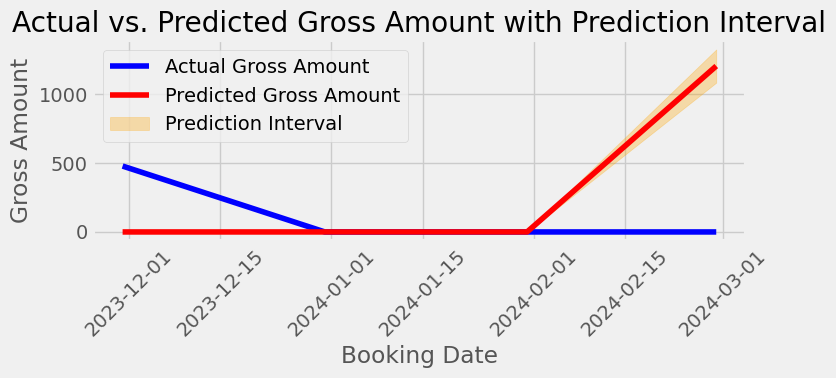

MAPE: inf
smape: 200.0
R-squared Score: -8.788411204621777
MAE: 421.1279972441543
RMSE: 648.6506841825479


C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 32471_Hamid & Kumar Enterprises LLC


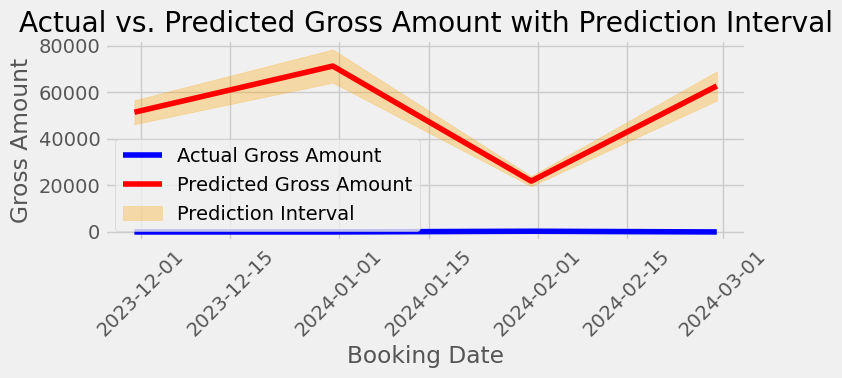

MAPE: inf
smape: 198.6611140808515
R-squared Score: -184153.48279612872
MAE: 51711.5013578323
RMSE: 55021.21684789874


C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 55967_Truebell Marketing and Trading LLC - UAE


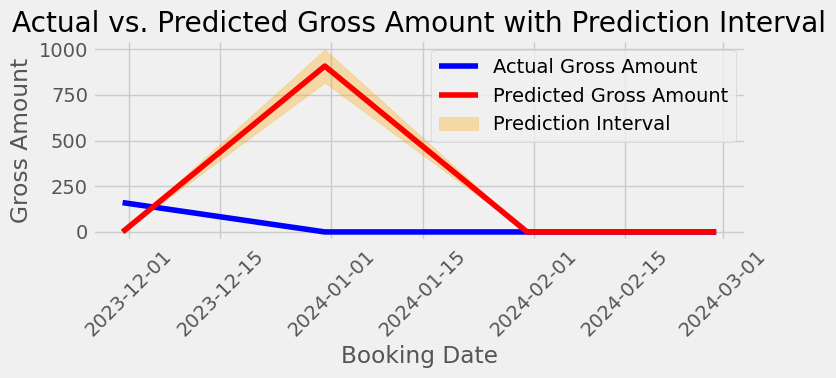

MAPE: inf
smape: 200.0
R-squared Score: -42.89454929851522
MAE: 267.07498076176995
RMSE: 460.8787273533488


C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 95556_Star Link Trading Co LLC


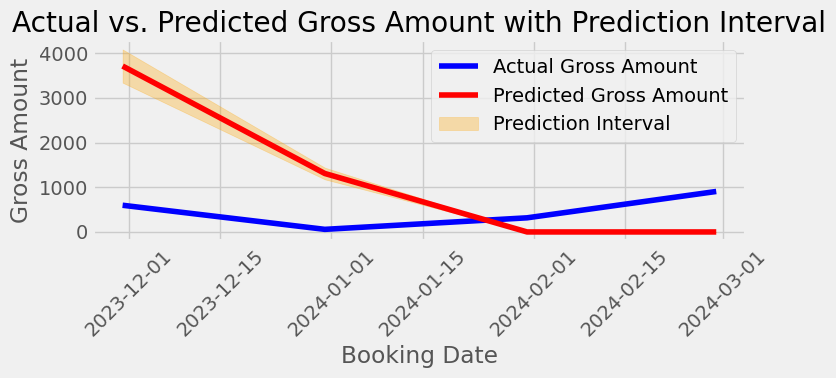

MAPE: 719.4882303122112
smape: 181.89736026975055
R-squared Score: -29.49299218041972
MAE: 1396.673513914346
RMSE: 1745.3893901360238


C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 92955_Sind Punjab Restaurant


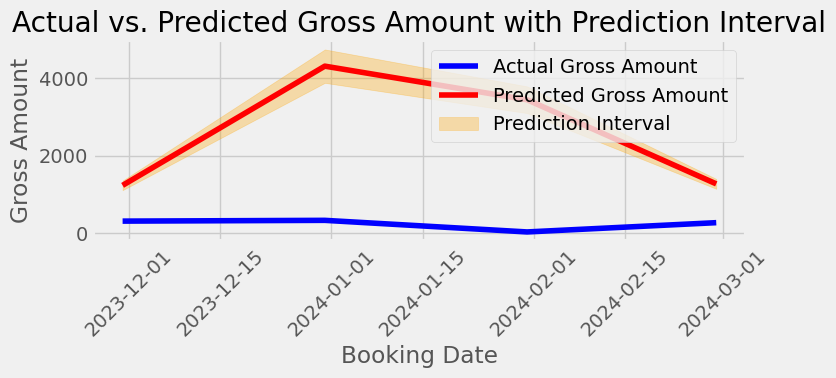

MAPE: 3318.8094020188323
smape: 154.47480563072875
R-squared Score: -507.6908862771002
MAE: 2327.8679734527104
RMSE: 2706.7563792471865


C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_8348\381431602.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)


combination: 27994_Sharif Hassan Ali Trading LLC



KeyboardInterrupt



In [36]:
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt
import io
doc = Document()

results_list = []



for i in unique_ids:
    try:
        df_filtered = df[(df['unique_id'] == i)]
        df_filtered['booking_date'] = pd.to_datetime(df_filtered['booking_date'])
        df_filtered.set_index('booking_date', inplace=True)
        df_filtered = df_filtered.resample('D').sum()
        df_filtered.reset_index('booking_date',inplace=True)
        last_booking_date = df_filtered['booking_date'].max()
        date_range = pd.date_range(start=last_booking_date + pd.DateOffset(days=1), end='2024-02-29')
        missing_dates_df = pd.DataFrame({'booking_date': date_range, 'gross_amount': 0,'property_name':0,'new_categoryId':0, 'Supplier':0, 'unique_id':0})
        filled_df = pd.concat([df_filtered, missing_dates_df])
        filled_df = filled_df.sort_values('booking_date')
        df_filtered=filled_df.copy()
        df_filtered = df_filtered.set_index('booking_date')

        df_filtered = df_filtered[['gross_amount']]
        df_filtered = df_filtered.resample('M').sum()

        sunday_dates = []

        def week_of_month(dt):
            """ Returns the week of the month for the specified date.
            """

            first_day = dt.replace(day=1)

            dom = dt.day
            adjusted_dom = dom + first_day.weekday()

            return int(ceil(adjusted_dom/7.0))


        def add_date_columns(df):
            df['booking_date'] = df.index
            # Add year, month, and week number columns
            df['Year'] = df['booking_date'].dt.year
            df['Month'] = df['booking_date'].dt.month
            df['Week_Number'] = df['booking_date'].apply(lambda x: week_of_month(x))

        def calculate_sunday_date(year, month, week_number):
            # Find the first day of the month
            first_day_of_month = pd.Timestamp(year, month, 1)
            # Calculate the weekday of the first day of the month (0: Monday, 6: Sunday)
            first_day_of_month_weekday = first_day_of_month.dayofweek
            # Calculate the number of days to the next Sunday
            days_to_sunday = 6 - first_day_of_month_weekday
            # Calculate the date of the first Sunday of the month
            first_sunday_of_month = first_day_of_month + pd.Timedelta(days=days_to_sunday)
            # Calculate the date of the Sunday corresponding to the specified week number
            sunday_date = first_sunday_of_month + pd.Timedelta(weeks=week_number - 1)
            return sunday_date


        add_date_columns(df_filtered)    

        df_weekly = df_filtered.groupby(['Year', 'Month', 'Week_Number']).agg({'gross_amount': 'sum'}).reset_index()

        grouped = df_weekly.groupby(['Year', 'Month'])

        # Iterate over each group
        for name, group in grouped:
            last_two_weeks = group.tail(2)
            last_day_of_month = calendar.monthrange(name[0], name[1])[1]
            weekday_of_last_day = calendar.weekday(name[0], name[1], last_day_of_month)
            # Check if the last day of the month is Sunday
            if weekday_of_last_day == 6:  # Sunday
                continue  # If the last day of the month is Sunday, skip summing the last two weeks
            else:
                sum_last_two_weeks = last_two_weeks['gross_amount'].sum()
                min_week_number = min(last_two_weeks['Week_Number'])
                df_weekly.loc[last_two_weeks.index, 'gross_amount'] = sum_last_two_weeks
                df_weekly.loc[last_two_weeks.index, 'Week_Number'] = min_week_number

        df_weekly = df_weekly.drop_duplicates()


        for index, row in df_weekly.iterrows():
            sunday_date = calculate_sunday_date(row['Year'].astype(int), row['Month'].astype(int), row['Week_Number'].astype(int))
            sunday_dates.append(sunday_date)

        df_weekly['Sunday_Date'] = sunday_dates

        columns_to_select = ['Sunday_Date', 'gross_amount']
        df_weekly = df_weekly[columns_to_select].copy()

        df_weekly = df_weekly.rename(columns={'Sunday_Date':'booking_date'})



        new_df = df_filtered.copy()
        # new_df.reset_index('booking_date',inplace=True)
        # new_df = df_weekly.copy()
        new_df['Year'] = new_df['booking_date'].dt.year
        new_df['Month'] = new_df['booking_date'].dt.month
        new_df['Week_Number'] = new_df['booking_date'].apply(lambda x: week_of_month(x))
    #     new_df['lag_1'] = new_df['gross_amount'].shift(1)
    #     new_df['lag_2'] = new_df['gross_amount'].shift(2)
    #     new_df['lag_3'] = new_df['gross_amount'].shift(3)
#         new_df['lag_4'] = new_df['gross_amount'].shift(4)
#         new_df['Rolling_SD'] = new_df['gross_amount'].rolling(window=4).std()
        # new_df.set_index('booking_date',inplace=True)
        new_df = new_df.dropna()

        train_dataset_end=datetime(2023,10,31)
        test_dataset_end=datetime(2024,2,29)

        train_data=new_df[:train_dataset_end]
        test_data=new_df[train_dataset_end+timedelta(days=1):test_dataset_end]

    #     pjme_train_prophet = train_data.reset_index().rename(columns={'booking_date':'ds',
    #                      'gross_amount':'y'})

        # train_data = train_data.reset_index()
        prophet_df = train_data.rename(columns={'booking_date': 'ds', 'gross_amount': 'y'})
    #     prophet_df = prophet_df.drop(columns={'property_name','CategoryID','Supplier','unique_id'})

        model = Prophet(interval_width = 0.8)
    #     model.add_country_holidays(country_name='AE')
    #     model.add_regressor('lag_1')
    #     model.add_regressor('lag_2')
    #     model.add_regressor('lag_3')
        model.add_regressor('Month')
        model.add_regressor('Week_Number')
        model.add_regressor('Year')
        model.fit(prophet_df)
        test_prophet = test_data
        # test_prophet = test_data.drop(columns={'gross_amount','property_name','CategoryID','Supplier','unique_id'})
        # test_prophet = test_prophet.reset_index()
        test_prophet.rename(columns={'booking_date': 'ds'}, inplace=True)
        forecast = model.predict(test_prophet)
        forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        forecast.rename(columns={'ds': 'booking_date', 'yhat':'predicted', }, inplace=True)
        test_data = test_data.reset_index()
        merged_df = pd.merge(test_data, forecast, on='booking_date', how='inner')
        merged_df[['booking_date', 'gross_amount', 'yhat_lower', 'yhat_upper', 'predicted']]
        merged_df = merged_df.set_index("booking_date")
        merged_df['predicted'] = merged_df['predicted'].apply(lambda x: max(0, x))
        resampled_data = merged_df[['gross_amount', 'predicted']].resample('M').sum()
        new_df = new_df[['gross_amount']].resample('M').sum()
        resampled_data = resampled_data.reset_index()

        def calculate_80_confidence_interval(x):
            lower_bound = x * 0.9
            upper_bound = x * 1.1
            return lower_bound, upper_bound

        # Apply the function to the 'predicted_total' column and store the result in a new DataFrame
        interval_df = resampled_data.apply(lambda row: pd.Series(calculate_80_confidence_interval(row['predicted'])), axis=1)

        # Rename columns for clarity
        interval_df.columns = ['lower_bound_80%', 'upper_bound_80%']

        # Concatenate the original DataFrame with the DataFrame containing the confidence intervals
        result_df = pd.concat([resampled_data, interval_df], axis=1)


        result_df = result_df.reset_index()

        result_df['booking_date'] = pd.to_datetime(result_df['booking_date'])

        print("combination:",i)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title('Actual vs. Predicted Gross Amount with Prediction Interval')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        r2 = r2_score(result_df['gross_amount'], result_df['predicted'])
        mape = mean_absolute_percentage_error(result_df['gross_amount'], result_df['predicted'])
        smape = calculate_smape(result_df['gross_amount'], result_df['predicted'])


        print("MAPE:", mape)
        print("smape:", smape)
        print("R-squared Score:", r2)
        print('MAE:', mean_absolute_error(result_df['gross_amount'], result_df['predicted']))
        print('RMSE:', np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted'])))

        results_list.append({'Combination': i, 'MAPE': mape, 'sMAPE_3': smape, 'R-squared': r2})

         #Writing to Word Document
        buf = io.BytesIO()
        plt.figure(figsize=(8, 4))
        plt.plot(result_df['booking_date'], result_df['gross_amount'], label='Actual Gross Amount', color='blue')
        plt.plot(result_df['booking_date'], result_df['predicted'], label='Predicted Gross Amount', color='red')
        plt.fill_between(result_df['booking_date'], result_df['lower_bound_80%'], result_df['upper_bound_80%'], color='orange', alpha=0.3, label='Prediction Interval')
        plt.xlabel('Booking Date')
        plt.ylabel('Gross Amount')
        plt.title(f'Actual vs. Predicted Gross Amount with Prediction Interval for ID {i}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(buf, format='png')
        plt.close()

        # Insert plot into the Word document
        doc.add_paragraph(f'Combination: {i}')
        doc.add_picture(buf, width=Inches(6))
        buf.close()

        # Write error metrics to the Word document
        doc.add_paragraph(f"R-squared Score: {r2}")
        doc.add_paragraph(f"MAPE: {mape}")
        doc.add_paragraph(f"sMAPE: {smape}")
        doc.add_paragraph(f"MAE: {mean_absolute_error(result_df['gross_amount'], result_df['predicted'])}")
        doc.add_paragraph(f"RMSE: {np.sqrt(mean_squared_error(result_df['gross_amount'], result_df['predicted']))}")
        doc.add_page_break()
    except ValueError as e:
        print(e)
        results_list.append({'Combination': i, 'MAPE': '-', 'sMAPE_3': '-', 'R-squared': '-'})
        pass
# doc.save("prophet_results.docx")
m3 = pd.DataFrame(results_list)
# m1.to_csv('m1.csv', index=False)


In [92]:
m3

Combination         MAPE  \
0                  32471_Hamid & Kumar Enterprises LLC          inf   
1                    95556_Saint Vincent Solutions LLC          inf   
2                  55967_Modern General Trading L.L.C.    50.024793   
3       55967_Truebell Marketing and Trading LLC - UAE          inf   
4                       95556_Star Link Trading Co LLC   719.492475   
5                         92955_Sind Punjab Restaurant  3103.493294   
6                        27994_Emirates Snack Food LLC   149.556288   
7                  27994_Sharif Hassan Ali Trading LLC    55.681985   
8                55967_JM - Jaber Measam Foodstuff LLC  4253.496466   
9                            27994_EMF Emirates L.L.C.          inf   
10                  19699_Chef Middle East L.L.C (UAE)    144.03665   
11           95438_Olfactory And Essences Global (Fzc)          inf   
12                            55967_MH Enterprises LLC          inf   
13                  56297_Chef Middle East L.L.C (UAE)   119.291669   
14                            27994_MH Enterprises LLC          inf   
15                            14985_MH Enterprises LLC          inf   
16                  67231_Chef Middle East L.L.C (UAE)   254.380579   
17                        95556_Joma Trading Co. L.L.C    42.555464   
18               17974_JM - Jaber Measam Foodstuff LLC          inf   
19                      17974_CHEF MIDDLE EAST (L.L.C)          inf   
20                  14985_Chef Middle East L.L.C (UAE)   153.961456   
21               27994_JM - Jaber Measam Foodstuff LLC   513.345616   
22       95556_Hussain Al Mulla General Trading L.L.C.     88.08398   
23                            27994_Hassani Trading Co          inf   
24                      92955_Sahar Enterprises L.L.C.    77.601494   
25                           55967_Horeca Trade L.L.C.   422.061412   
26                                       11732_Java TR   103.563681   
27                   59527_Aramtec General Trading LLC   338.433141   
28             27994_Hamid and Kumar Enterprises (Dry)          inf   
29              55967_IFFCO DISTRIBUTION SERVICES FZCO          NaN   
30     19699_Al Buheira Lacnor Dairies Co.L.L.C (NFPC)          inf   
31         27994_Greenhouse Foodstuff Trading LLC (AE)          inf   
32           55967_Al Marai Emirates Company LLC - UAE          inf   
33           19699_Al Marai Emirates Company LLC - UAE          inf   
34                 92955_Allfood Foodstuff trading LLC        100.0   
35                       27994_H.K. Enterprises L.L.C.     24.64729   
36                       92955_H.K. Enterprises L.L.C.          inf   
37                        14985_Gulf International LLC    78.321871   
38                                  21551_Bakemart LLC          inf   
39                            95556_Beauty Leaders LLC          inf   
40            19699_Classic Fine Foodstuff Trading LLC    75.167487   
41                  32471_Chef Middle East L.L.C (UAE)    75.509975   
42                        14985_Sind Punjab Restaurant          inf   
43                            92955_Indoguna Dubai LLC          inf   
44                   46911_Aramtec General Trading LLC          inf   
45      46911_Truebell Marketing and Trading LLC - UAE   561.453222   
46                                12199_Lebanon Sweets   396.541612   
47                          12199_La Patissiere L.L.C.          inf   
48                           92955_Horeca Trade L.L.C.        100.0   
49                         95438_Bin Hilal Enterprises    53.174702   
50                                 95556_Restofair RAK          inf   
51                        27994_WJ Towell & Co (L.L.C)          inf   
52                  59527_Chef Middle East L.L.C (UAE)    91.096085   
53           67231_Mitras International Trading L.L.C.          inf   
54                          59527_M.H. Enterprises LLC          inf   
55              46911_Augur Star General Trading L.L.C          inf

In [31]:
combined_df = m1[['Combination','sMAPE_1']]
combined_df['sMAPE_2'] = m2['sMAPE_2']
combined_df['sMAPE_3'] = m3['sMAPE_3']
# combined_df['sMAPE_4'] = m_df_l4_sd_my['sMAPE_4']
# combined_df['sMAPE_5'] = m_df_l8_sd_my['sMAPE_5']
# combined_df['sMAPE_6'] = m_df_l4_sd_my_h['sMAPE_6']
# combined_df['sMAPE_0'] = m_df_fb['sMAPE_0']
combined_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_4948\2288848087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['sMAPE_2'] = m2['sMAPE_2']


Combination     sMAPE_1  \
0                           92955_La Patissiere L.L.C.   74.186598   
1       27994_Truebell Marketing and Trading LLC - UAE   86.248204   
2                        55967_H.K. Enterprises L.L.C.   26.659349   
3                  27994_Sharif Hassan Ali Trading LLC  102.911381   
4                       19699_Barakat Quality Plus LLC   52.252678   
5                           67231_M.H. Enterprises LLC   41.128347   
6            55967_Al Marai Emirates Company LLC - UAE  171.544027   
7                         27994_Sind Punjab Restaurant   14.409995   
8                           12199_La Patissiere L.L.C.  165.509866   
9              95556_Al Tanoof Electricals LLC (Dubai)   58.987475   
10                       62535_Admirals Trading L.L.C.  112.856078   
11           15628_Mitras International Trading L.L.C.  150.927404   
12           95438_Olfactory And Essences Global (Fzc)  169.353021   
13                       27994_Emirates Snack Food LLC   68.488173   
14                  27836_Diamond Meat Processing Est.  176.614049   
15               15628_JM - Jaber Measam Foodstuff LLC  108.906895   
16       95556_Hussain Al Mulla General Trading L.L.C.   56.160015   
17                  46911_Chef Middle East L.L.C (UAE)   83.008902   
18                        32452_Hasanat Trading Co LLC  102.948281   
19                     11732_Xpert General Trading LLC   65.092740   
20                      36997_Barakat Quality Plus LLC  175.277144   
21               97993_JM - Jaber Measam Foodstuff LLC   33.699841   
22                 95556_Fine Hygienic Paper FZE - UAE   18.480194   
23           19699_Al Marai Emirates Company LLC - UAE  150.850909   
24                      55967_Barakat Quality Plus LLC   69.237849   
25                   15628_Aramtec General Trading LLC   96.678501   
26                        27994_WJ Towell & Co (L.L.C)  190.470179   
27                       46911_Emirates Snack Food LLC   28.196153   
28               14985_JM - Jaber Measam Foodstuff LLC  176.470266   
29           62535_Mitras International Trading L.L.C.   86.613463   
30     19699_Al Buheira Lacnor Dairies Co.L.L.C (NFPC)  108.706999   
31                          15628_M.H. Enterprises LLC   53.029550   
32                    55298_Alliance Foods Company LLC   43.724644   
33               11732_Al Qutbi Building Materials LLC  136.541054   
34               46911_JM - Jaber Measam Foodstuff LLC  108.417373   
35   55967_Majid Al Futtaim Hypermarkets B2B (Br of...  179.732693   
36                  27994_Pulsar FoodStaff Trading LLC  124.902594   
37            92955_Classic Fine Foodstuff Trading LLC  187.771700   
38                        95556_Joma Trading Co. L.L.C   27.305365   
39           17974_Mitras International Trading L.L.C.  102.608722   
40                     32452_Xpert General Trading LLC   26.591252   
41             62535_Golden Dunes General Trading LLC.  177.609151   
42                         95556_Bin Hilal Enterprises   36.667106   
43              55967_IFFCO Distribution Services FZCO  147.820255   
44                         95438_Bin Hilal Enterprises  104.084966   
45                   92955_Health Plus General Trading  109.163776   
46               95556_Al Qutbi Building Materials LLC   92.101731   
47           55298_Mitras International Trading L.L.C.  124.069514   
48                      17974_CHEF MIDDLE EAST (L.L.C)   52.449651   
49                       27994_H.K. Enterprises L.L.C.   30.996340   
50                  27836_Chef Middle East L.L.C (UAE)  104.637552   
51                       14727_Admirals Trading L.L.C.  130.368131   
52                   95556_Saint Vincent Solutions LLC  123.950903   
53                     95556_Footflex Shoe Trading LLC   50.937343   
54                                 21551_Modern Bakery   20.016744   
55                           92955_Horeca Trade L.L.C.  133.945361   
56                                  27994_Bakemart LL

In [32]:
import pandas as pd

# Assuming df is your dataframe with columns 'Combination', 'sMAPE_1', 'sMAPE_2', ..., 'sMAPE_n'
# Find the index of the column with the minimum value for each combination
min_col_index = combined_df.iloc[:, 1:].idxmin(axis=1)

# Create a new dataframe to store the results
result_df = pd.DataFrame({
    'Combination': combined_df['Combination'],
    'Best_Column': min_col_index.str.replace('sMAPE_', '')
})

# Print the result dataframe
(result_df)


Combination Best_Column
0                           92955_La Patissiere L.L.C.           1
1       27994_Truebell Marketing and Trading LLC - UAE           2
2                        55967_H.K. Enterprises L.L.C.           2
3                  27994_Sharif Hassan Ali Trading LLC           2
4                       19699_Barakat Quality Plus LLC           1
5                           67231_M.H. Enterprises LLC           3
6            55967_Al Marai Emirates Company LLC - UAE           2
7                         27994_Sind Punjab Restaurant           1
8                           12199_La Patissiere L.L.C.           2
9              95556_Al Tanoof Electricals LLC (Dubai)           1
10                       62535_Admirals Trading L.L.C.           2
11           15628_Mitras International Trading L.L.C.           3
12           95438_Olfactory And Essences Global (Fzc)           1
13                       27994_Emirates Snack Food LLC           2
14                  27836_Diamond Meat Processing Est.           2
15               15628_JM - Jaber Measam Foodstuff LLC           1
16       95556_Hussain Al Mulla General Trading L.L.C.           1
17                  46911_Chef Middle East L.L.C (UAE)           1
18                        32452_Hasanat Trading Co LLC           2
19                     11732_Xpert General Trading LLC           3
20                      36997_Barakat Quality Plus LLC           2
21               97993_JM - Jaber Measam Foodstuff LLC           1
22                 95556_Fine Hygienic Paper FZE - UAE           1
23           19699_Al Marai Emirates Company LLC - UAE           2
24                      55967_Barakat Quality Plus LLC           3
25                   15628_Aramtec General Trading LLC           2
26                        27994_WJ Towell & Co (L.L.C)           2
27                       46911_Emirates Snack Food LLC           1
28               14985_JM - Jaber Measam Foodstuff LLC           2
29           62535_Mitras International Trading L.L.C.           2
30     19699_Al Buheira Lacnor Dairies Co.L.L.C (NFPC)           2
31                          15628_M.H. Enterprises LLC           1
32                    55298_Alliance Foods Company LLC           2
33               11732_Al Qutbi Building Materials LLC           3
34               46911_JM - Jaber Measam Foodstuff LLC           1
35   55967_Majid Al Futtaim Hypermarkets B2B (Br of...           2
36                  27994_Pulsar FoodStaff Trading LLC           3
37            92955_Classic Fine Foodstuff Trading LLC           2
38                        95556_Joma Trading Co. L.L.C           1
39           17974_Mitras International Trading L.L.C.           3
40                     32452_Xpert General Trading LLC           1
41             62535_Golden Dunes General Trading LLC.           2
42                         95556_Bin Hilal Enterprises           2
43              55967_IFFCO Distribution Services FZCO           3
44                         95438_Bin Hilal Enterprises           3
45                   92955_Health Plus General Trading           1
46               95556_Al Qutbi Building Materials LLC           3
47           55298_Mitras International Trading L.L.C.           3
48                      17974_CHEF MIDDLE EAST (L.L.C)           1
49                       27994_H.K. Enterprises L.L.C.           3
50                  27836_Chef Middle East L.L.C (UAE)           3
51                       14727_Admirals Trading L.L.C.           1
52                   95556_Saint Vincent Solutions LLC           1
53                     95556_Footflex Shoe Trading LLC           1
54                                 21551_Modern Bakery           2
55                           92955_Horeca Trade L.L.C.           2
56                                  27994_Bakemart LLC           2
57                          46911_Gourmet Distribution           1
58                       27994_Admirals Trading L.L.C.           1
59      55967_Truebell 

In [33]:
result_df.to_csv('result_df_prophet.csv', index=False)
